In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico.nc')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, 3) # 3 means open boundary in both dimensions
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
solvers[.66].medium['cloud'].reff.data[np.where(carved_volume.mask.data == 0)] = 0

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in sensors.get_unique_solvers():
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
size_distribution_function = at3d.size_distribution.gamma
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    maxnphase=1e9,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)
print(solvers)
# We are using the ground_truth rte_grid.
#dataset = dataset.reset_coords(['reff'], drop=True)

SolversDict([(0.66, <at3d.solver.RTE object at 0x7fa418623d90>)])


In [2]:
# def train(max_iter = 20, ftol = 1e-6):

#     solvers_reconstruct = copy.deepcopy(solvers)
#     solvers_reconstruct[.66].medium['cloud'].veff.data = carved_volume.mask.data.astype(float)*0 + .1
#     solvers_reconstruct[.66].medium['cloud'].reff.data = carved_volume.mask.data.astype(float)*0 + 15
#     solvers_reconstruct[.66].medium['cloud'].density.data = carved_volume.mask.data.astype(float)*0 + 0

#     uncertainty_density = at3d.uncertainties.NullUncertainty('L2',i*1e10)
#     uncertainty_reff = at3d.uncertainties.NullUncertainty('L2',i*1e14)

#     data_with_reff = solvers_reconstruct[.66].medium['cloud'].drop_vars("density")
#     data_with_density = solvers_reconstruct[.66].medium['cloud'].drop_vars("reff")

#     micro_grid_with_reff = at3d.medium.MicrophysicsGridToOpticalProperties(
#         rte_grid, optical_property_generator, data_with_reff
#     )

#     micro_grid_with_density = at3d.medium.MicrophysicsGridToOpticalProperties(
#         rte_grid, optical_property_generator, data_with_density
#     )

#     unknown_scatterer_density = at3d.containers.UnknownScatterers(
#         at3d.medium.UnknownScatterer(micro_grid_with_reff,
#         # density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), relative_scaling_density * 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
#         density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
#         )
#     )

#     unknown_scatterer_reff = at3d.containers.UnknownScatterers(
#         at3d.medium.UnknownScatterer(micro_grid_with_density,
#         # density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), relative_scaling_density * 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
#         reff=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
#         )
#     )

#     state_gen_density = at3d.medium.StateGenerator(solvers_reconstruct,
#                                             unknown_scatterer_density, surfaces,
#                                             numerical_parameters, sources, background_optical_scatterers,
#                                             num_stokes)
    
#     state_gen_reff = at3d.medium.StateGenerator(solvers_reconstruct,
#                                             unknown_scatterer_reff, surfaces,
#                                             numerical_parameters, sources, background_optical_scatterers,
#                                             num_stokes)
    
#     min_bounds_density, max_bounds_density = state_gen_density.transform_bounds()
#     forward_sensors_density = sensors.make_forward_sensors()

#     min_bounds_reff, max_bounds_reff = state_gen_reff.transform_bounds()
#     forward_sensors_reff = sensors.make_forward_sensors()

#     curr_unknown = "density"

#     def plot_density(optimizer):
#         fig, axs = py.subplots(1, 2, figsize=(12, 6))  # Create a figure with subplots side by side
#         # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
#         #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
#         # axs[0].plot([0,130],[0,130])
#         axs[1].plot(solvers_reconstruct_density[0.66].medium['cloud'].density.data.ravel(), 
#                 solvers[0.66].medium['cloud'].density.data.ravel(),'x')
#         axs[1].plot([0,2],[0,2])
#         axs[0].plot(solvers_reconstruct_density[0.66].medium['cloud'].reff.data.ravel(), 
#                 solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
#         axs[0].plot([0,20],[0,20])
#         #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
#                 #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
#         #axs[3].plot([0,30],[0,30])
#         # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
#         #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
#         #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
#         #         uncertainty_kwargs={'add_noise': False})()
#         # grads = optimizer_reff.objective(optimizer_reff._state)[1]
#         # print(grads.shape)
#         # print(grads.mean())
#         # print(grads.std())
#         py.show()
#         return {'None': None}
#     callback = at3d.callback.CallbackFn(plot_density)

#     if curr_unknown == "density":
#         initial_gridded_density = solvers_reconstruct[.66].medium['cloud'].density.data
#         initial_1d_density = state_gen_density._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_density)
#         x0 = state_gen_density._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_density)
#         sensors.add_uncertainty_model('MSPI', uncertainty_density)
#         objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
#             sensors, solvers_reconstruct, forward_sensors_reff, unknown_scatterer_reff, state_gen_reff,
#             state_gen_reff.project_gradient_to_state,
#             parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
#             gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
#             uncertainty_kwargs={'add_noise': False},
#             min_bounds=min_bounds_reff, max_bounds=max_bounds_reff
#         )
#     else:
#         initial_gridded_reff = solvers_reconstruct[.66].medium['cloud'].reff.data
#         initial_1d_reff = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
#         x0 = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)
#         sensors.add_uncertainty_model('MSPI', uncertainty_reff)
#         objective_function_reff = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
#             sensors, solvers_reconstruct, forward_sensors_reff, unknown_scatterer_reff, state_gen_reff,
#             state_gen_reff.project_gradient_to_state,
#             parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
#             gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
#             uncertainty_kwargs={'add_noise': False},
#             min_bounds=min_bounds_reff, max_bounds=max_bounds_reff
#         )

In [3]:
def train_density(solvers_reconstruct_reff, i, ftol=1e66):
    uncertainty_density = at3d.uncertainties.NullUncertainty('L2',i*1e9) #replaces original uncertainty
    sensors.add_uncertainty_model('MSPI', uncertainty_density)

    data_with_reff = solvers_reconstruct_reff[.66].medium['cloud'].drop_vars("density")
    data_with_reff = data_with_reff.drop_vars("extinction")

    micro_grid_with_reff = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, data_with_reff
    )

    unknown_scatterer_density = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(micro_grid_with_reff,
        # density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        )
    )

    # now we form state_gen which updates the solvers with an input_state.
    solvers_reconstruct_density = at3d.containers.SolversDict()

    state_gen_density = at3d.medium.StateGenerator(solvers_reconstruct_density,
                                            unknown_scatterer_density, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)

    regularization = at3d.regularization.Tikhonov(state_gen_density, "cloud", "density", 20.0)

    min_bounds_density, max_bounds_density = state_gen_density.transform_bounds()
    forward_sensors_density = sensors.make_forward_sensors()

    initial_gridded_density = solvers_reconstruct_reff[.66].medium['cloud'].density.data
    initial_1d_density = state_gen_density._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_density)
    x2 = state_gen_density._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_density)

    objective_function_density = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct_density, forward_sensors_density, unknown_scatterer_density, state_gen_density,
    state_gen_density.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds_density, max_bounds=max_bounds_density)


    def plot_density(optimizer):
        fig, axs = py.subplots(1, 2, figsize=(12, 6))  # Create a figure with subplots side by side
        # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
        #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
        # axs[0].plot([0,130],[0,130])
        axs[1].plot(solvers_reconstruct_density[0.66].medium['cloud'].density.data.ravel(), 
                solvers[0.66].medium['cloud'].density.data.ravel(),'x')
        axs[1].plot([0,200],[0,200])
        axs[0].plot(solvers_reconstruct_density[0.66].medium['cloud'].reff.data.ravel(), 
                solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
        axs[0].plot([0,20],[0,20])
        #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
                #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
        #axs[3].plot([0,30],[0,30])
        # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
        #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        #         uncertainty_kwargs={'add_noise': False})()
        # grads = optimizer_reff.objective(optimizer_reff._state)[1]
        # print(grads.shape)
        # print(grads.mean())
        # print(grads.std())
        py.show()
        return {'None': None}
    callback_density = at3d.callback.CallbackFn(plot_density)

    import warnings
    optimizer_density = at3d.optimize.Optimizer(objective_function_density, prior_fn=regularization, callback_fn=callback_density, options={'maxiter': 30, 'maxls': 10, 'disp': True, 'ftol': ftol})
    warnings.filterwarnings('ignore')
    optimizer_density._options['maxiter'] = 5
    result_density = optimizer_density.minimize(x2)
    return solvers_reconstruct_density, np.linalg.norm(result_density.jac), result_density.fun 

In [4]:
import at3d.regularization


def train_reff(solvers_reconstruct_density, i, ftol=1e6):
    uncertainty_reff = at3d.uncertainties.NullUncertainty('L2', 1e11) #replaces original uncertainty
    sensors.add_uncertainty_model('MSPI', uncertainty_reff)

    data_with_extinction = solvers_reconstruct_density[.66].medium['cloud'].drop_vars("reff")
    data_with_extinction = data_with_extinction.drop_vars("extinction")

    micro_grid_with_extinction = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, data_with_extinction
    )

    relative_scaling_reff = np.std(solvers[.66].medium['cloud'].reff.data)
    unknown_scatterer_reff = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(micro_grid_with_extinction,
        # reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
        reff=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].reff.data), 1.0/np.std(solvers[.66].medium['cloud'].reff.data)), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
        )
    )

    # now we form state_gen which updates the solvers with an input_state.
    solvers_reconstruct_reff = at3d.containers.SolversDict()

    state_gen_reff = at3d.medium.StateGenerator(solvers_reconstruct_reff,
                                            unknown_scatterer_reff, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    
    regularization = at3d.regularization.Tikhonov(state_gen_reff, "cloud", "reff", 20.0)

    min_bounds_reff, max_bounds_reff = state_gen_reff.transform_bounds()
    forward_sensors_reff = sensors.make_forward_sensors()

    initial_gridded_reff = solvers_reconstruct_density[.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x1 = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

    objective_function_reff = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct_reff, forward_sensors_reff, unknown_scatterer_reff, state_gen_reff,
    state_gen_reff.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds_reff, max_bounds=max_bounds_reff)


    def plot_reff(optimizer):
        fig, axs = py.subplots(1, 2, figsize=(12, 6))  # Create a figure with subplots side by side
        # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
        #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
        # axs[0].plot([0,130],[0,130])
        axs[1].plot(solvers_reconstruct_reff[0.66].medium['cloud'].density.data.ravel(), 
                solvers[0.66].medium['cloud'].density.data.ravel(),'x')
        axs[1].plot([0,200],[0,200])
        axs[0].plot(solvers_reconstruct_reff[0.66].medium['cloud'].reff.data.ravel(), 
                solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
        axs[0].plot([0,20],[0,20])
        #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
                #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
        #axs[3].plot([0,30],[0,30])
        # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
        #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        #         uncertainty_kwargs={'add_noise': False})()
        # grads = optimizer_reff.objective(optimizer_reff._state)[1]
        # print(grads.shape)
        # print(grads.mean())
        # print(grads.std())
        py.show()
        return {'None': None}
    callback_reff = at3d.callback.CallbackFn(plot_reff)

    import warnings
    optimizer_reff = at3d.optimize.Optimizer(objective_function_reff,prior_fn=regularization, callback_fn=callback_reff, options={'maxiter': 30, 'maxls': 10, 'disp': True, 'ftol': ftol})
    warnings.filterwarnings('ignore')
    optimizer_reff._options['maxiter'] = 5
    result_reff = optimizer_reff.minimize(x1)
    return solvers_reconstruct_reff, np.linalg.norm(result_reff.jac), result_reff.fun

In [5]:
def train_reff_full(solvers_reconstruct_density, i, ftol=1e6):
    uncertainty_reff = at3d.uncertainties.NullUncertainty('L2',i*1e14) #replaces original uncertainty
    sensors.add_uncertainty_model('MSPI', uncertainty_reff)

    data_with_extinction = solvers_reconstruct_density[.66].medium['cloud'].drop_vars("reff")
    data_with_extinction = data_with_extinction.drop_vars("extinction")

    micro_grid_with_extinction = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, data_with_extinction
    )

    relative_scaling_reff = 1
    unknown_scatterer_reff = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(micro_grid_with_extinction,
        reff=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        )
    )

    # now we form state_gen which updates the solvers with an input_state.
    solvers_reconstruct_reff = at3d.containers.SolversDict()

    state_gen_reff = at3d.medium.StateGenerator(solvers_reconstruct_reff,
                                            unknown_scatterer_reff, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)

    min_bounds_reff, max_bounds_reff = state_gen_reff.transform_bounds()
    forward_sensors_reff = sensors.make_forward_sensors()

    initial_gridded_reff = solvers_reconstruct_density[.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x1 = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

    objective_function_reff = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct_reff, forward_sensors_reff, unknown_scatterer_reff, state_gen_reff,
    state_gen_reff.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds_reff, max_bounds=max_bounds_reff)


    def plot_reff(optimizer):
        fig, axs = py.subplots(1, 2, figsize=(12, 6))  # Create a figure with subplots side by side
        # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
        #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
        # axs[0].plot([0,130],[0,130])
        axs[1].plot(solvers_reconstruct_reff[0.66].medium['cloud'].density.data.ravel(), 
                solvers[0.66].medium['cloud'].density.data.ravel(),'x')
        axs[1].plot([0,200],[0,200])
        axs[0].plot(solvers_reconstruct_reff[0.66].medium['cloud'].reff.data.ravel(), 
                solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
        axs[0].plot([0,20],[0,20])
        #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
                #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
        #axs[3].plot([0,30],[0,30])
        # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
        #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        #         uncertainty_kwargs={'add_noise': False})()
        # grads = optimizer_reff.objective(optimizer_reff._state)[1]
        # print(grads.shape)
        # print(grads.mean())
        # print(grads.std())
        py.show()
        return {'None': None}
    callback_reff = at3d.callback.CallbackFn(plot_reff)

    import warnings
    optimizer_reff = at3d.optimize.Optimizer(objective_function_reff,callback_fn=callback_reff, options={'maxiter': 30, 'maxls': 10, 'disp': True, 'ftol': ftol})
    warnings.filterwarnings('ignore')
    optimizer_reff._options['maxiter'] = 5
    result_reff = optimizer_reff.minimize(x1)
    return solvers_reconstruct_reff, np.linalg.norm(result_reff.jac), result_reff.fun

In [6]:
# import copy
# solvers_reconstruct = copy.deepcopy(solvers)
# solvers_reconstruct[.66].medium['cloud'].veff.data = carved_volume.mask.data.astype(float)*0 + .1
# solvers_reconstruct[.66].medium['cloud'].reff.data = carved_volume.mask.data.astype(float)*0 + 15
# solvers_reconstruct[.66].medium['cloud'].density.data = carved_volume.mask.data.astype(float)*0 + 0
# iter = 30
# density_grad_loss = None
# initial_density_grad_loss = None
# initial_reff_grad_loss = None
# scale_factor = 1e-4
# init_loss = None
# losses = []
# for i in range(iter):
#     print("------ Epoch " + str(i) + " ------")
#     if i == 0:
#         print("------ Optimizing Density and Reff ------")
#         solvers_reconstruct, grad, loss = train_density(solvers_reconstruct, 1)
#         density_grad_loss = grad * loss
#         solvers_reconstruct, grad, loss = train_reff(solvers_reconstruct, 1)
#         reff_grad_loss = scale_factor * grad * loss
#         initial_density_grad_loss = density_grad_loss
#         initial_reff_grad_loss = reff_grad_loss
#         init_loss = loss * scale_factor
#         print(density_grad_loss)
#         print(reff_grad_loss)
#     else:
#         if reff_grad_loss <= density_grad_loss:
#             print("------ Optimizing Density ------")
#             scale = 9**(2*(initial_density_grad_loss-density_grad_loss)/(initial_density_grad_loss+density_grad_loss))
#             solvers_reconstruct, grad, loss = train_density(solvers_reconstruct, scale, init_loss/(5*i) / scale)
#             losses.append(loss / scale)
#             density_grad_loss = grad * loss / scale
#             print(density_grad_loss)
#         else:
#             print("------ Optimizing Reff ------")
#             scale = 9**(2*(initial_reff_grad_loss-reff_grad_loss)/(initial_reff_grad_loss+reff_grad_loss))
#             solvers_reconstruct, grad, loss = train_reff(solvers_reconstruct, scale, init_loss/(5*i) * scale_factor / scale)
#             losses.append(loss*scale_factor / scale)
#             reff_grad_loss = scale_factor * grad * loss / scale
#             print(reff_grad_loss)
#     if(i % 5 == 0):
#         py.plot(losses)
#         py.axhline(y=init_loss * .01, color='r', linestyle='--')
#         py.show()
# # for i in range(5):
# #     solvers_reconstruct = train_reff_full(solvers_reconstruct, i+1)

------ Epoch 0 ------
------ Optimizing Density and Reff ------


/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_71693/40579792.py:5: RuntimeWarning: divide by zero encountered in true_divide
  solvers[.66].medium['cloud']["density"] = (("x", "y", "z"), 3e6 * solvers[.66].medium['cloud'].lwc.data / (2 * 997.0 * solvers[.66].medium['cloud'].reff.data))
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_71693/40579792.py:5: RuntimeWarning: invalid value encountered in true_divide
  solvers[.66].medium['cloud']["density"] = (("x", "y", "z"), 3e6 * solvers[.66].medium['cloud'].lwc.data / (2 * 997.0 * solvers[.66].medium['cloud'].reff.data))


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


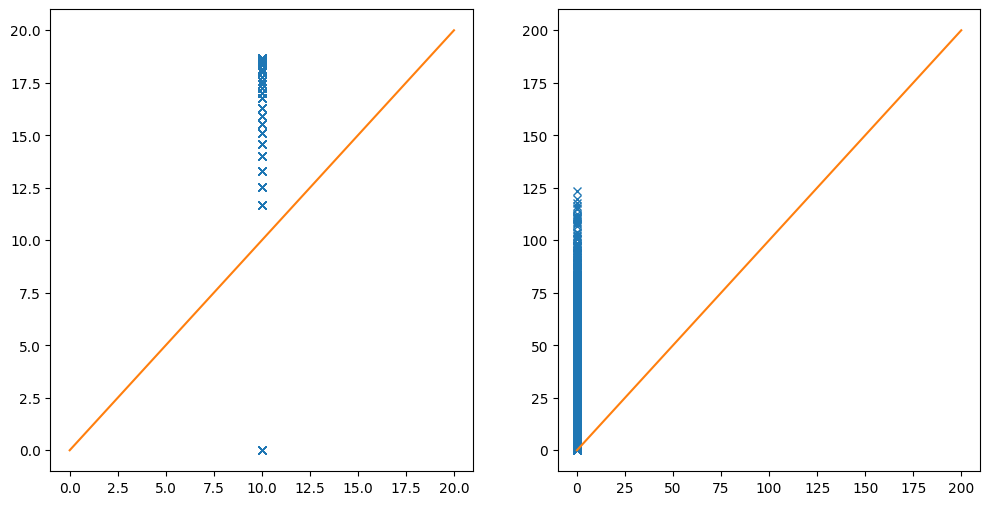

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9037     M =           10

At X0      9037 variables are exactly at the bounds

At iterate    0    f=  5.91438D+05    |proj g|=  1.67283D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.633  0.734E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.128  0.750E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.569  0.769E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.881  0.539E+00    32007    79.04  0.309   [Radiance 0.660 micron]
     5  -2.381  0.252E+00    32121    79.39  0.310   [Radiance 0.660 micron]
     6  -2.668  0.100E+00    32465    80.56  0.315   [Radiance 0.660 micron]
     7  -2.633  0.473E-01    34522    87.33  0.341   [Radiance 0.660 micron]
     8  -2.697  0.335E-01    36913    94.62  0.370   [Radiance 0.660 micron]
     9  -2.978  0.300E-01    38029    97.92  0.382   [Radiance 0.660 micron]
    

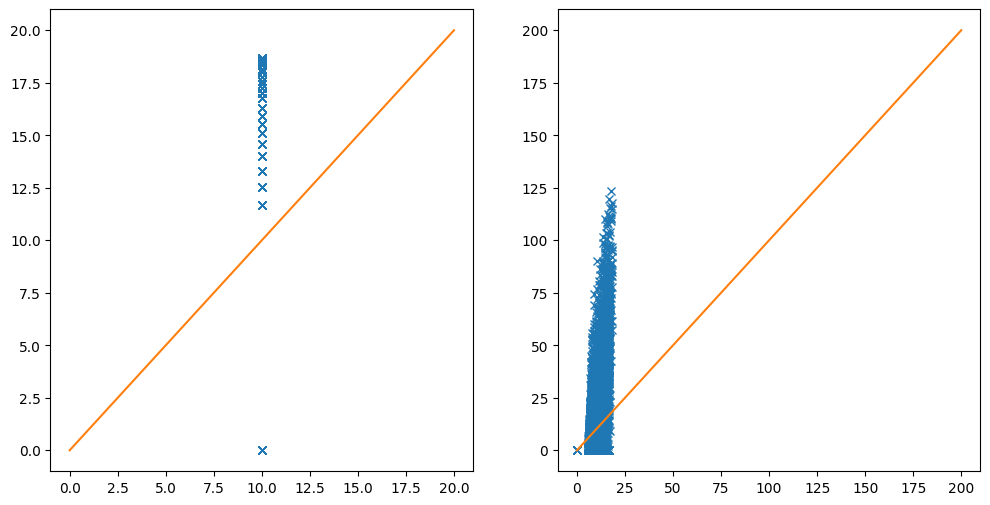

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.246  0.112E-03    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.103  0.112E-03    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


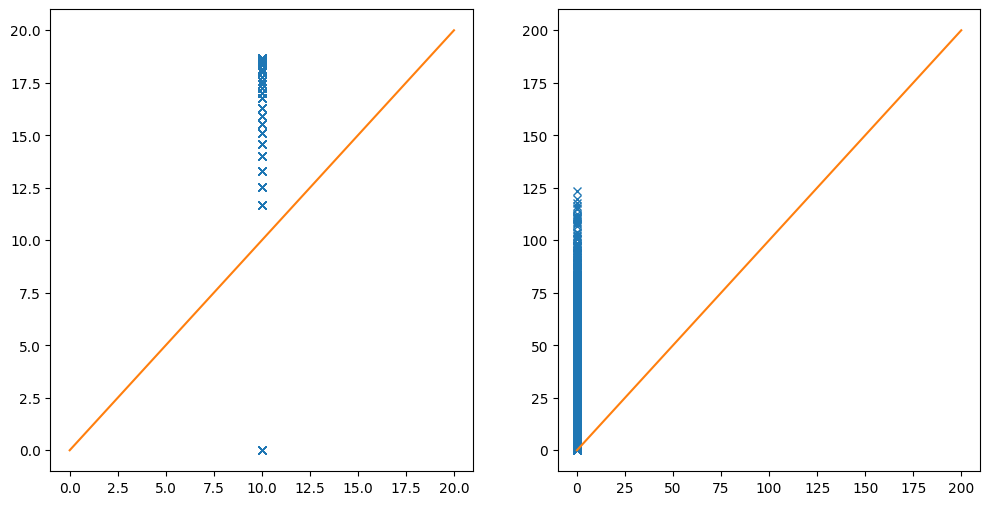

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.678  0.570E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.268  0.562E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.827  0.555E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -2.268  0.300E+00    32031    79.14  0.309   [Radiance 0.660 micron]
     5  -3.041  0.122E+00    32200    79.66  0.311   [Radiance 0.660 micron]
     6  -2.870  0.300E-01    33684    84.61  0.331   [Radiance 0.660 micron]
     7  -3.272  0.300E-01    33684    84.61  0.331   [Radiance 0.660 micron]
     8  -4.309  0.300E-01    33684    84.61  0.331   [Radiance 0.660 micron]
 ! Iterations:      8     Final Criterion:  0.000049   [Radiance 0.660 micron]


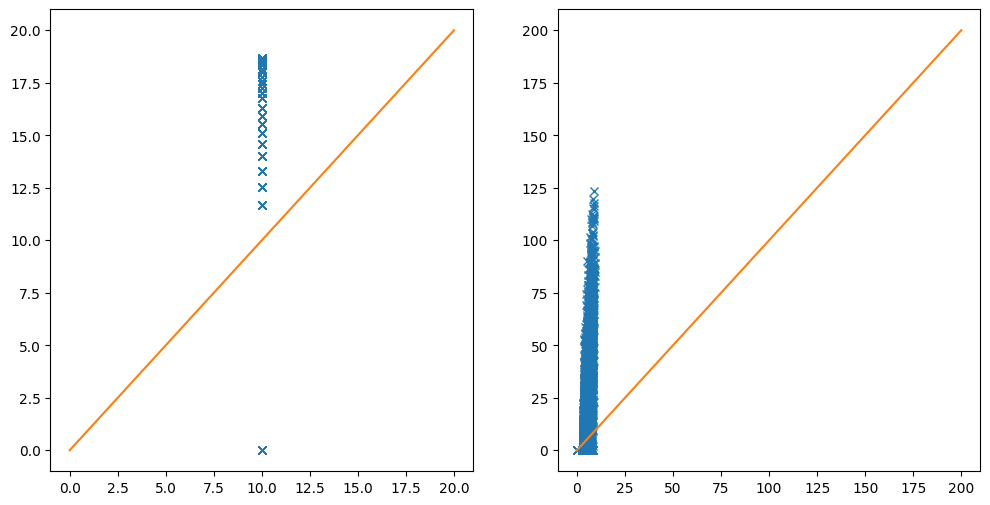

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.257  0.235E-03    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.110  0.235E-03    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000078   [Radiance 0.660 micron]


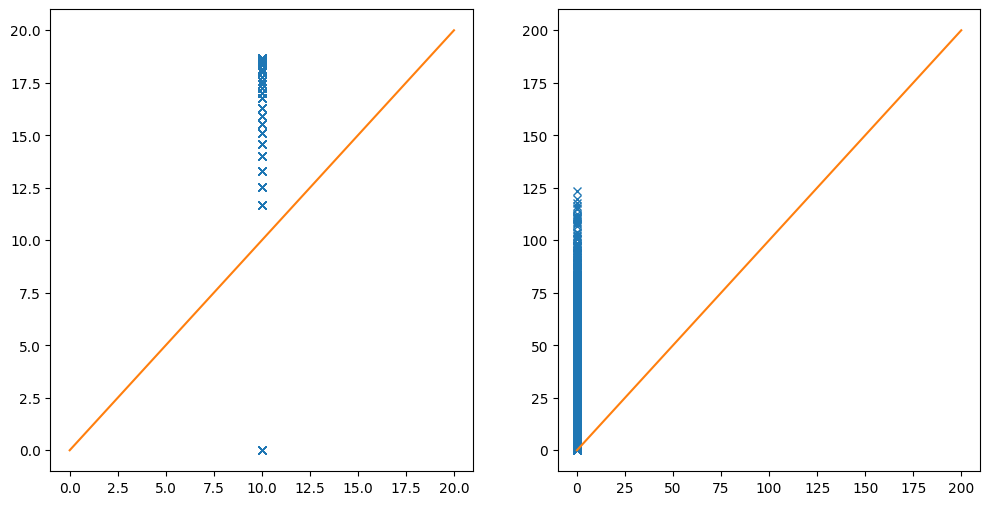

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.257  0.235E-03    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.110  0.236E-03    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000078   [Radiance 0.660 micron]


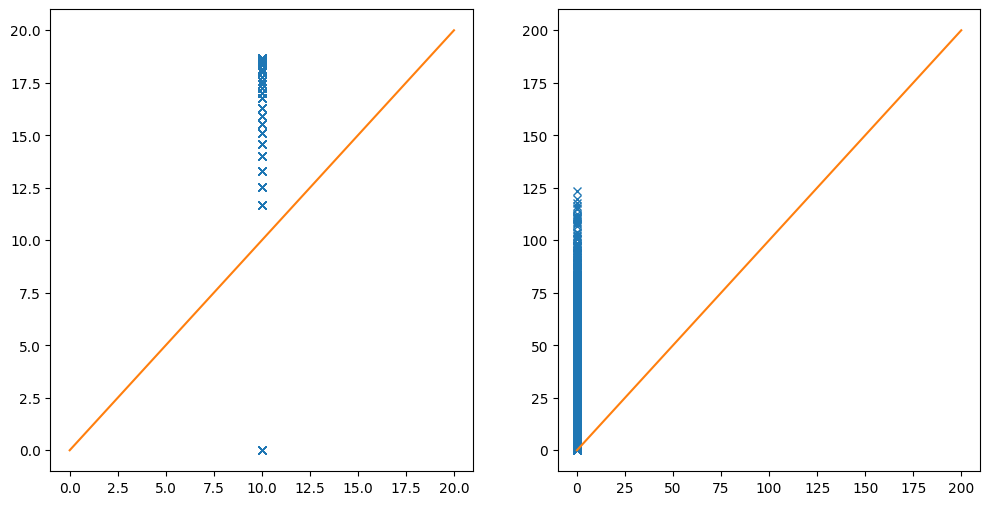

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.763  0.365E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.476  0.345E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -2.272  0.339E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -2.955  0.131E+00    32079    79.23  0.309   [Radiance 0.660 micron]
     5  -3.609  0.441E-01    32332    80.06  0.313   [Radiance 0.660 micron]
     6  -3.747  0.297E-01    32451    80.33  0.314   [Radiance 0.660 micron]
     7  -4.814  0.297E-01    32451    80.33  0.314   [Radiance 0.660 micron]
 ! Iterations:      7     Final Criterion:  0.000015   [Radiance 0.660 micron]


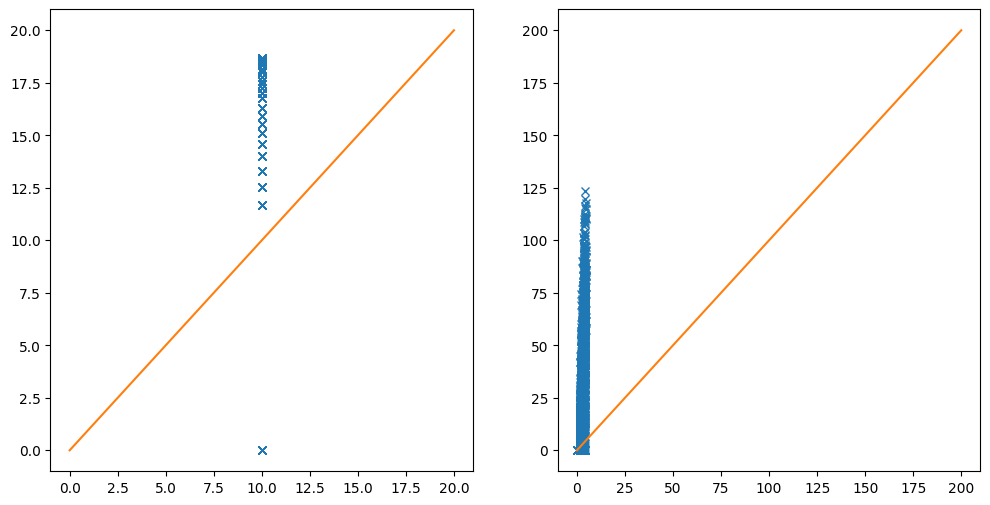

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.269  0.367E-03    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.118  0.367E-03    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000076   [Radiance 0.660 micron]


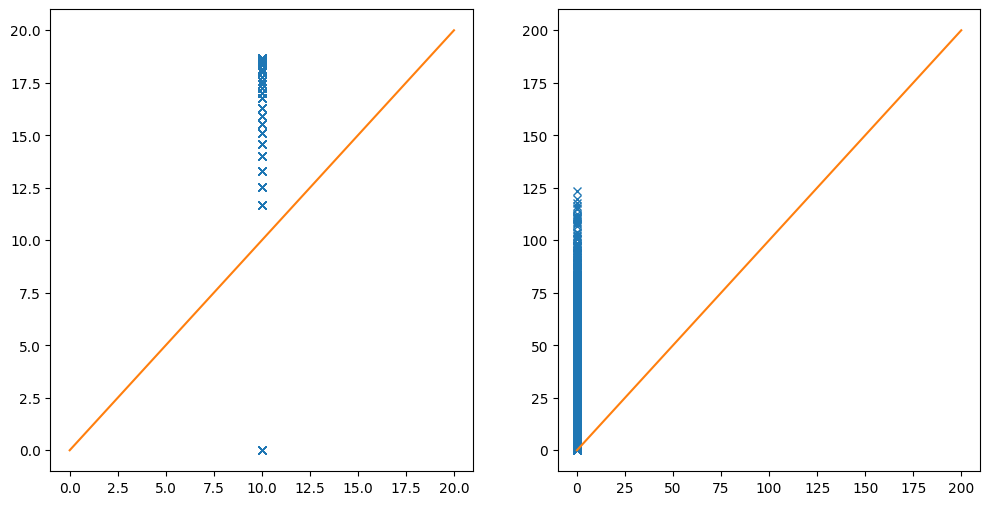

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.269  0.367E-03    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.118  0.368E-03    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000076   [Radiance 0.660 micron]


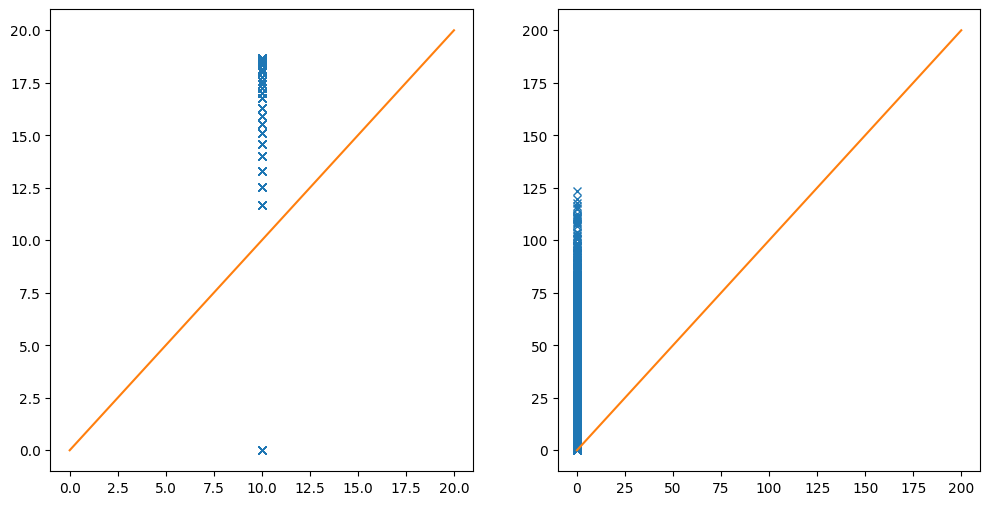

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.890  0.207E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.800  0.190E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -2.944  0.163E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     4  -3.851  0.538E-01    32110    79.27  0.310   [Radiance 0.660 micron]
     5  -3.999  0.300E-01    32269    79.93  0.312   [Radiance 0.660 micron]
     6  -5.205  0.300E-01    32269    79.93  0.312   [Radiance 0.660 micron]
 ! Iterations:      6     Final Criterion:  0.000006   [Radiance 0.660 micron]


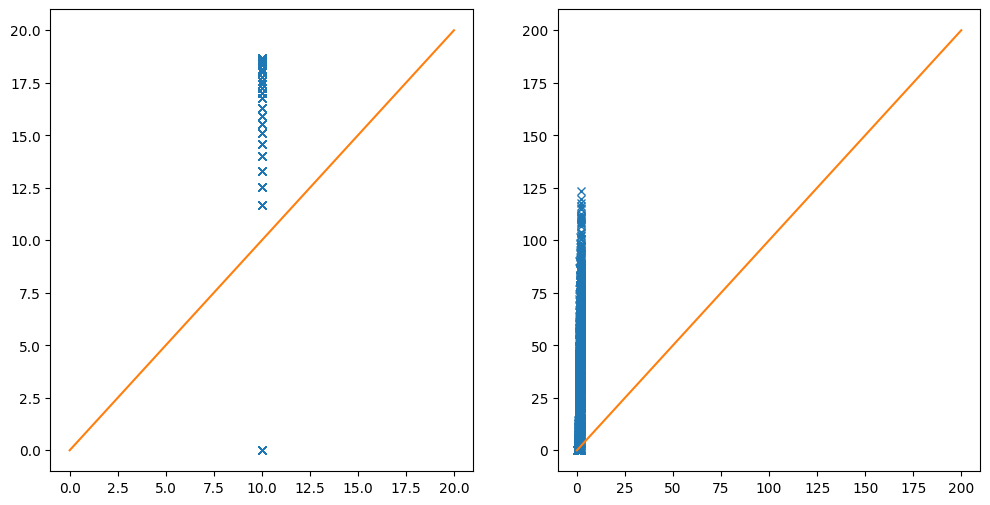

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.282  0.515E-03    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.128  0.516E-03    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000074   [Radiance 0.660 micron]


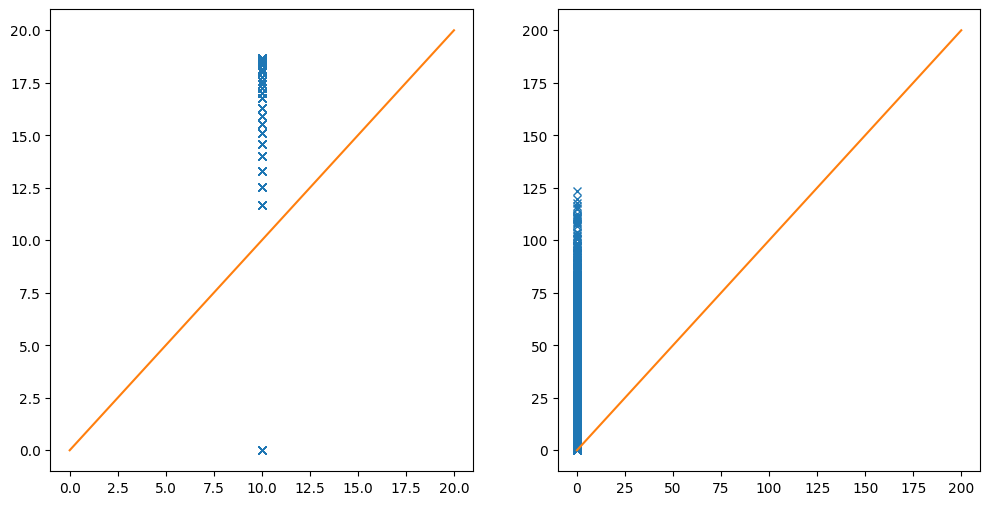


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9037      1     11      1     0     0   1.673D+00   5.914D+05
  F =   591438.34264883806     

ABNORMAL_TERMINATION_IN_LNSRCH                              
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.282  0.515E-03    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.128  0.516E-03    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000074   [Radiance 0.660 micron]


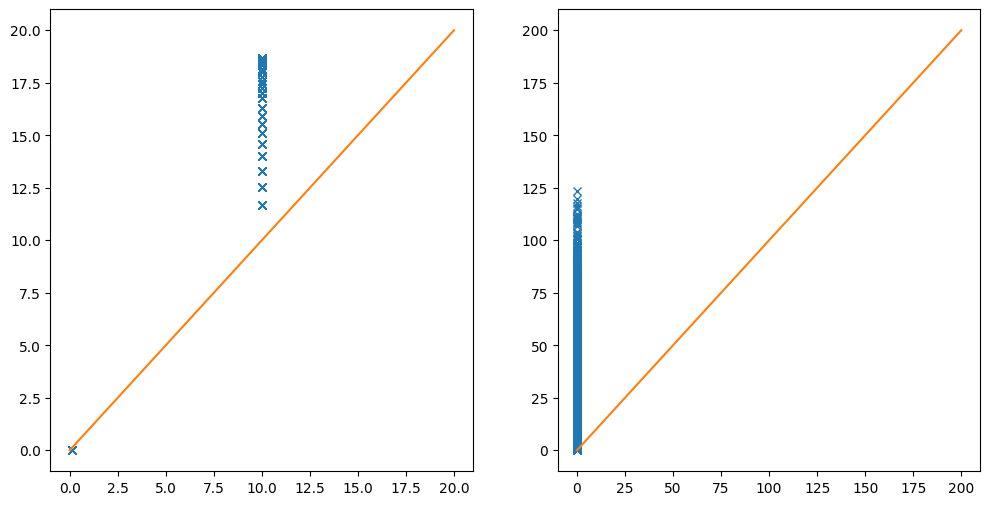

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72084D+07    |proj g|=  1.39768D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.240  0.149E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


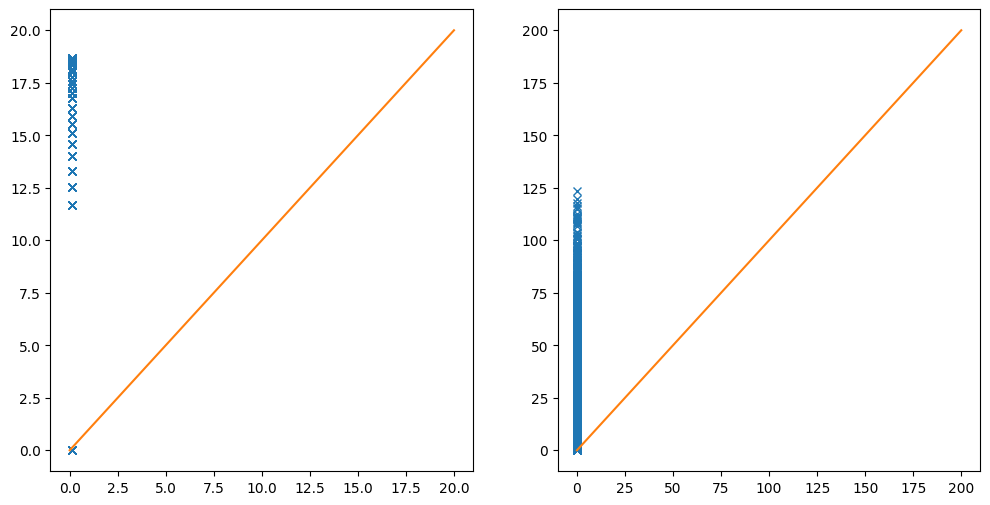


At iterate    1    f=  5.91368D+07    |proj g|=  4.22128D+00


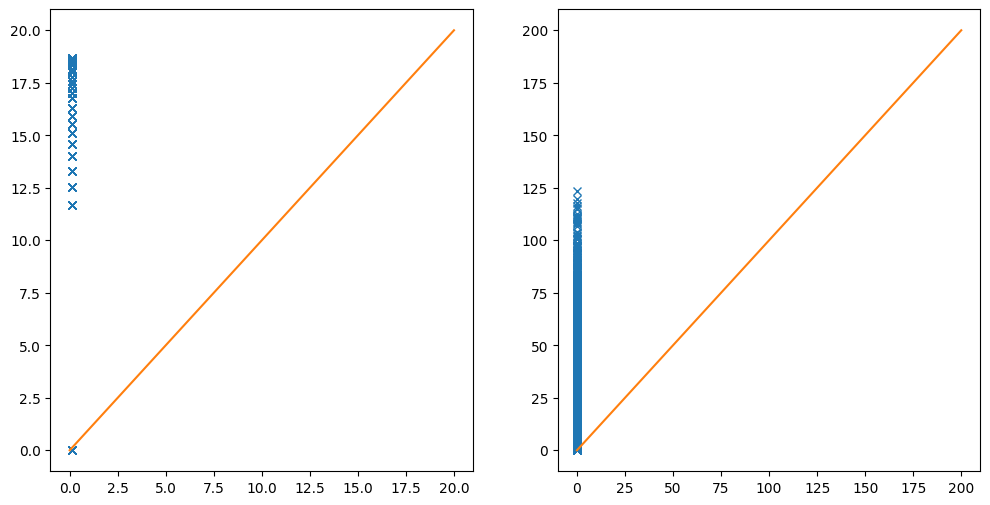


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      2     27     0    27   4.221D+00   5.914D+07
  F =   59136791.239562646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


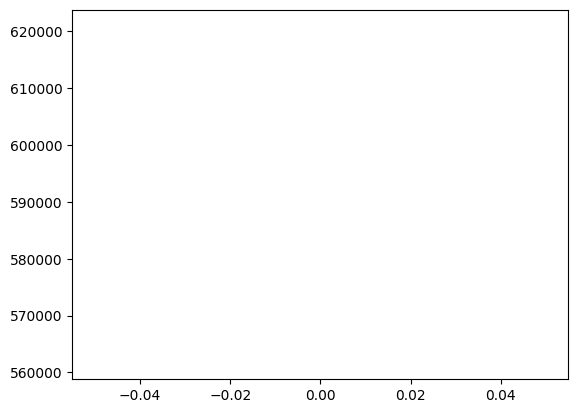

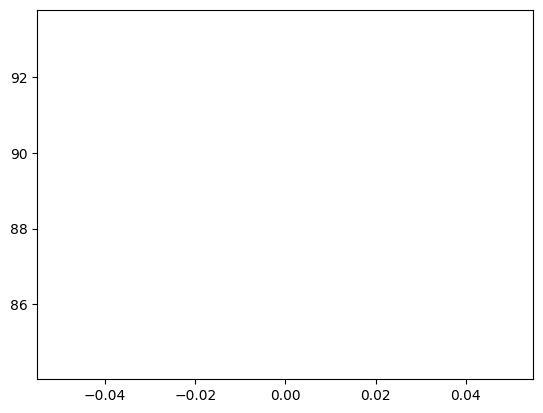

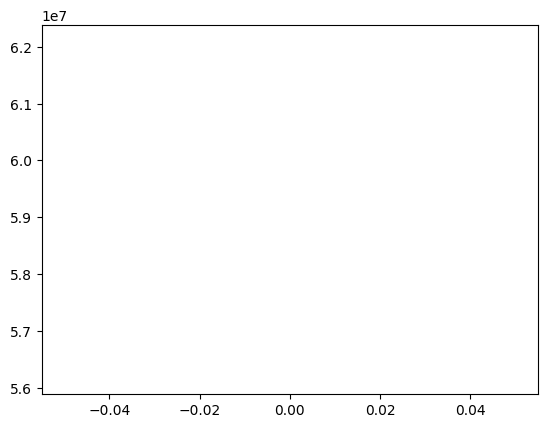

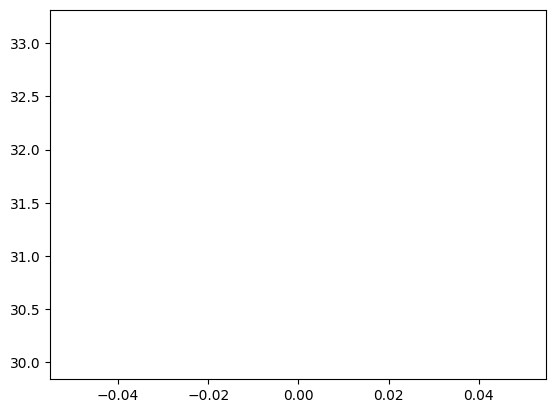

------ Epoch 1 ------
------ Optimizing Density ------
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.240  0.149E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


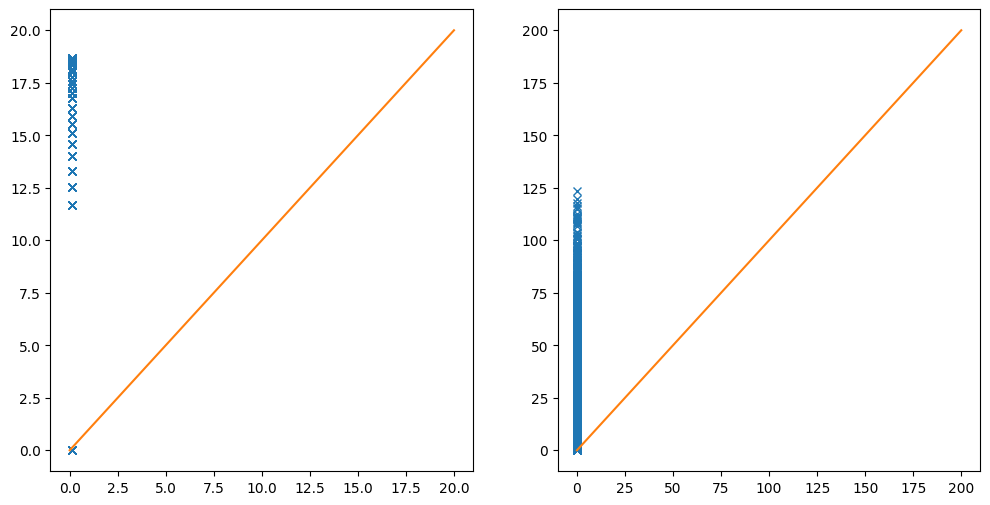

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9037     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91306D+05    |proj g|=  1.75457D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.946  0.694E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.923  0.556E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -3.181  0.482E-01    31984    78.91  0.308   [Radiance 0.660 micron]
     4  -4.069  0.297E-01    32036    79.17  0.309   [Radiance 0.660 micron]
 ! Iterations:      4     Final Criterion:  0.000085   [Radiance 0.660 micron]


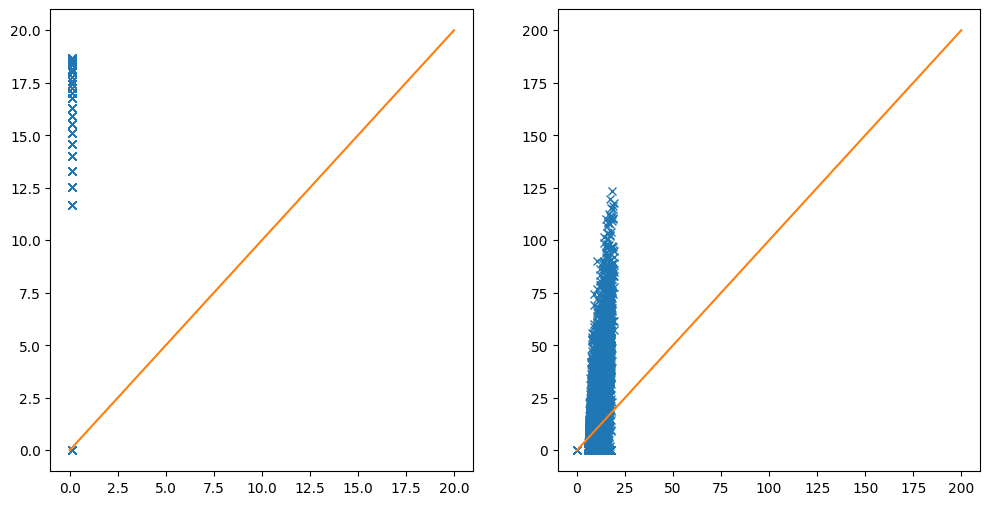

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.241  0.149E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


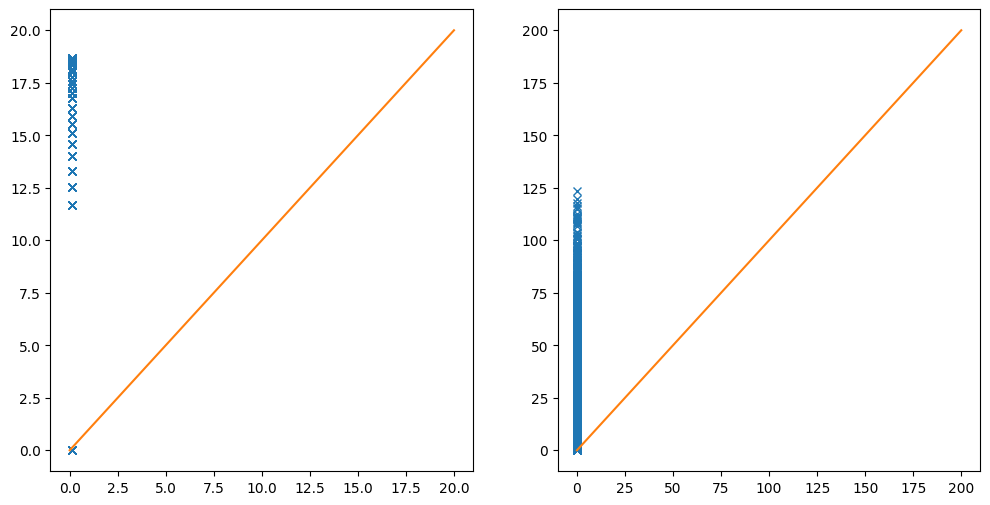

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.124  0.330E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -2.382  0.281E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -3.983  0.280E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -5.226  0.280E-01    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      4     Final Criterion:  0.000006   [Radiance 0.660 micron]


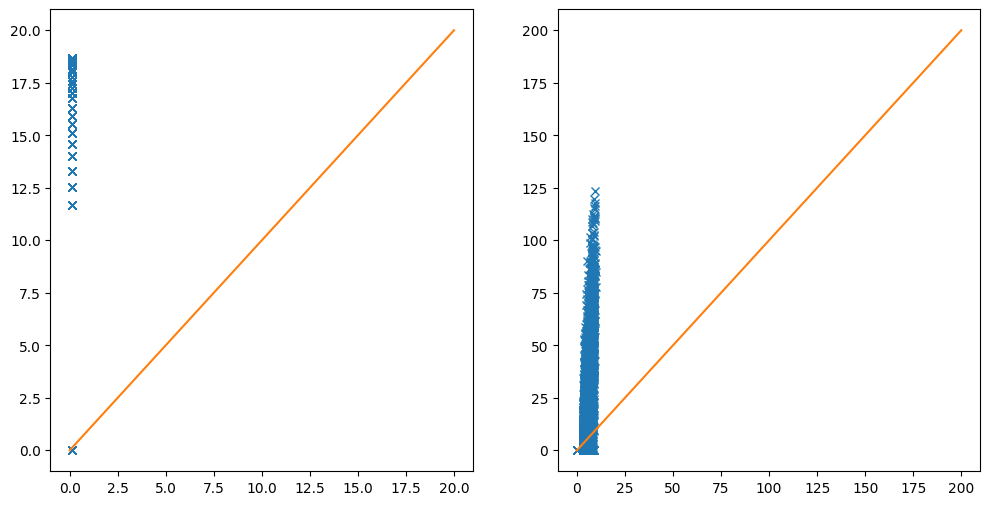

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.242  0.165E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.166E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


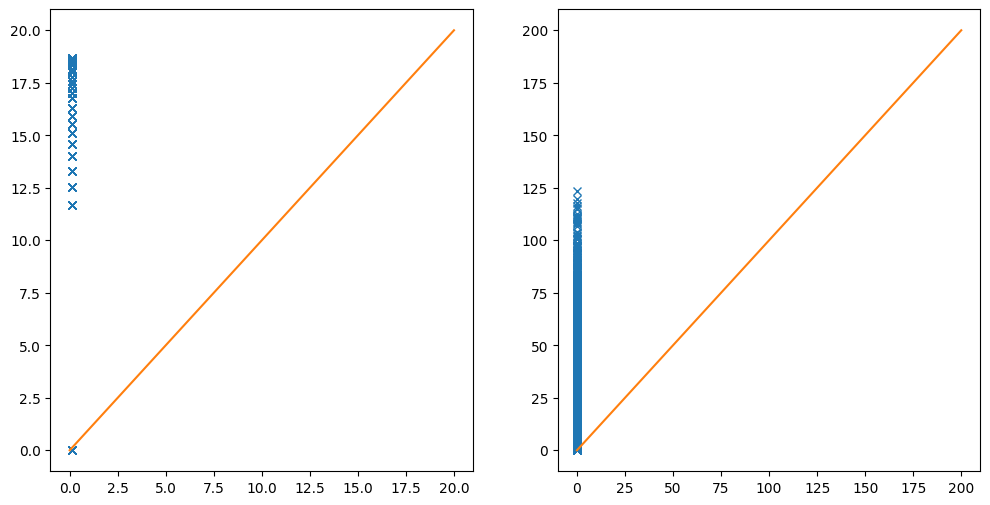

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.242  0.165E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.166E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


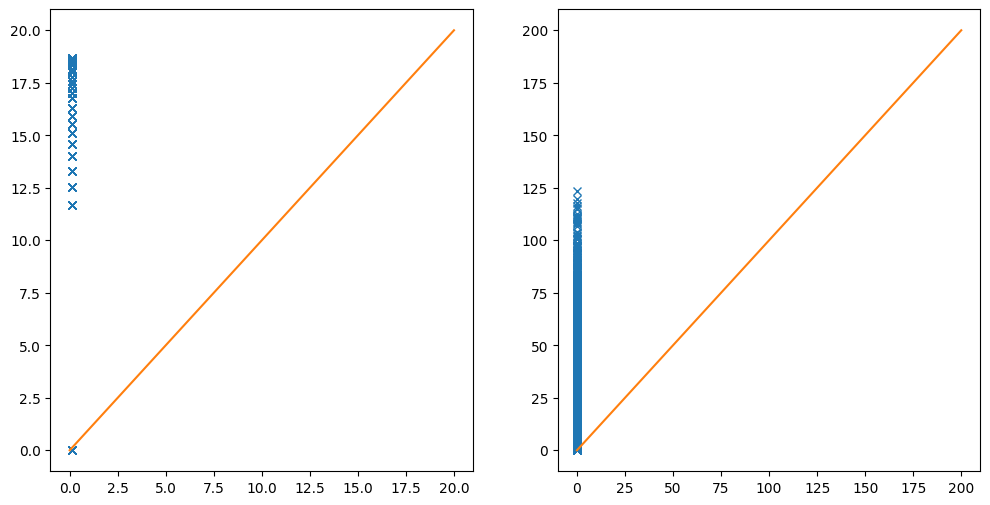

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.362  0.155E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -2.925  0.141E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -4.813  0.141E-01    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000015   [Radiance 0.660 micron]


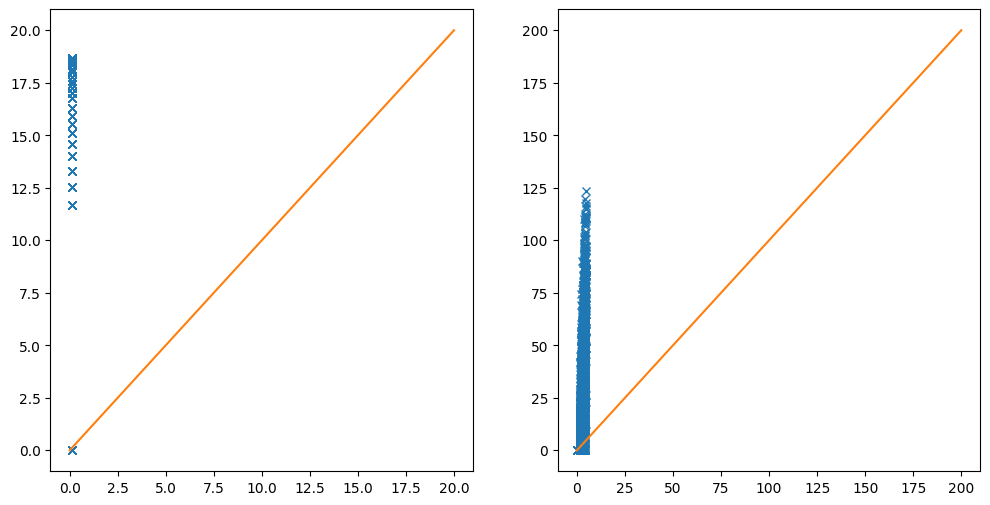

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.242  0.204E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.204E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


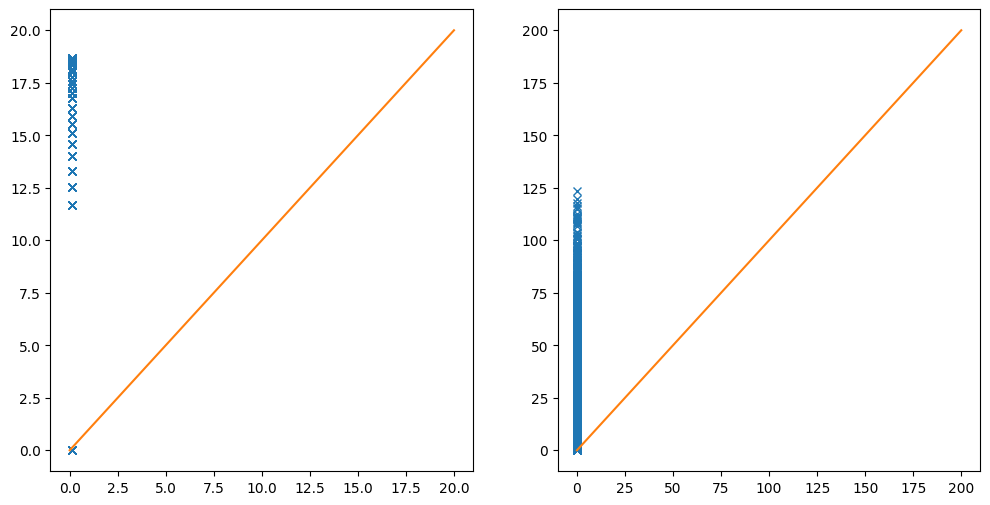

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.242  0.204E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.205E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


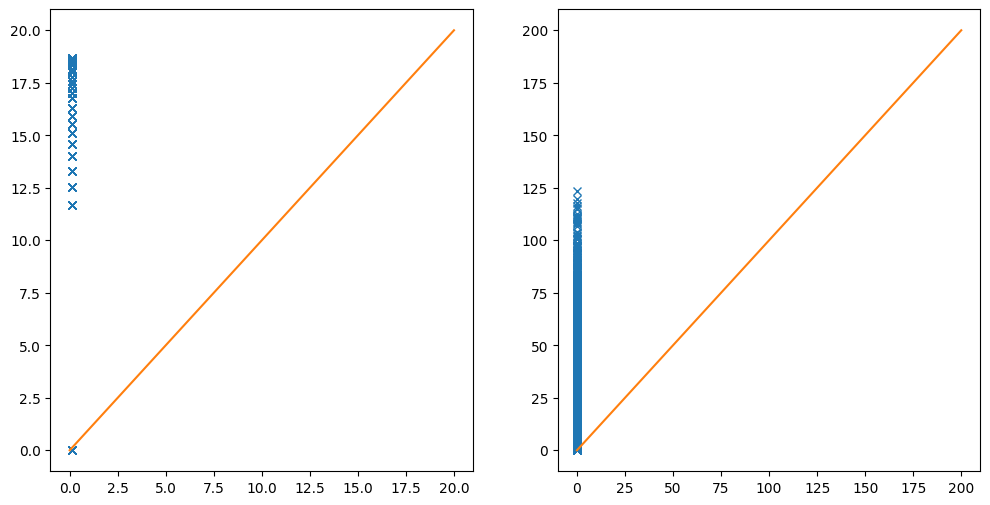

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.639  0.740E-02    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -3.546  0.711E-02    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -5.746  0.710E-02    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000002   [Radiance 0.660 micron]


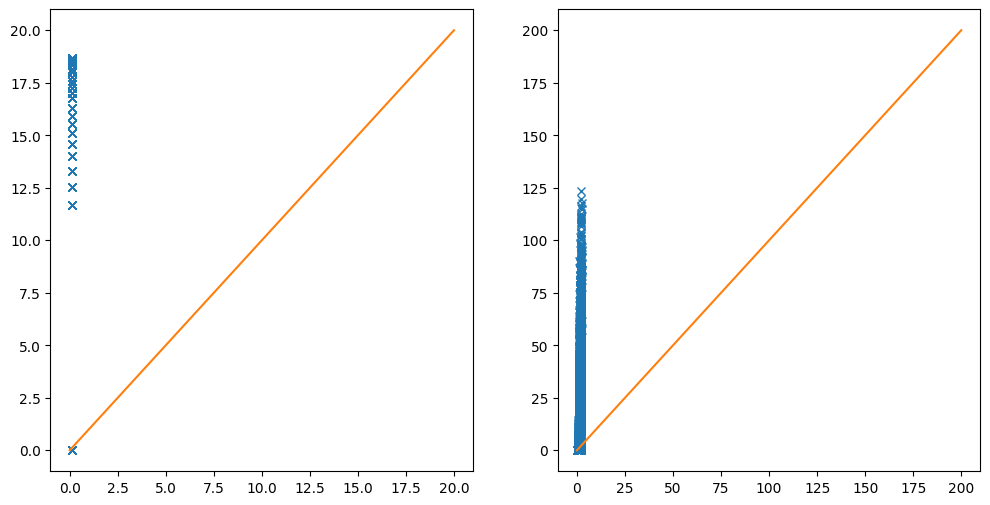

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.243  0.247E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.248E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


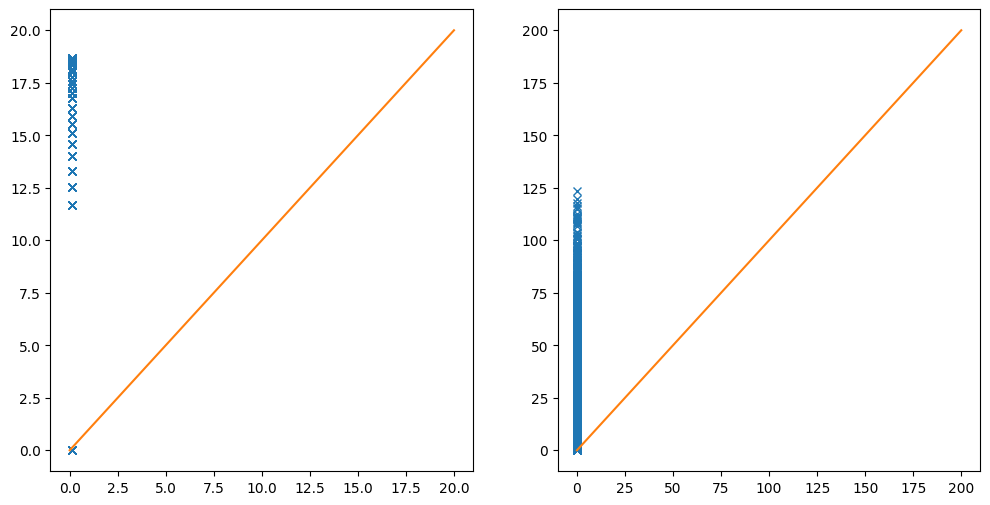


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9037      1     11      1     0     0   1.755D+00   5.913D+05
------ Epoch 2 ------
------ Optimizing Reff ------
  F =   591305.83042815921     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.243  0.247E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.248E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


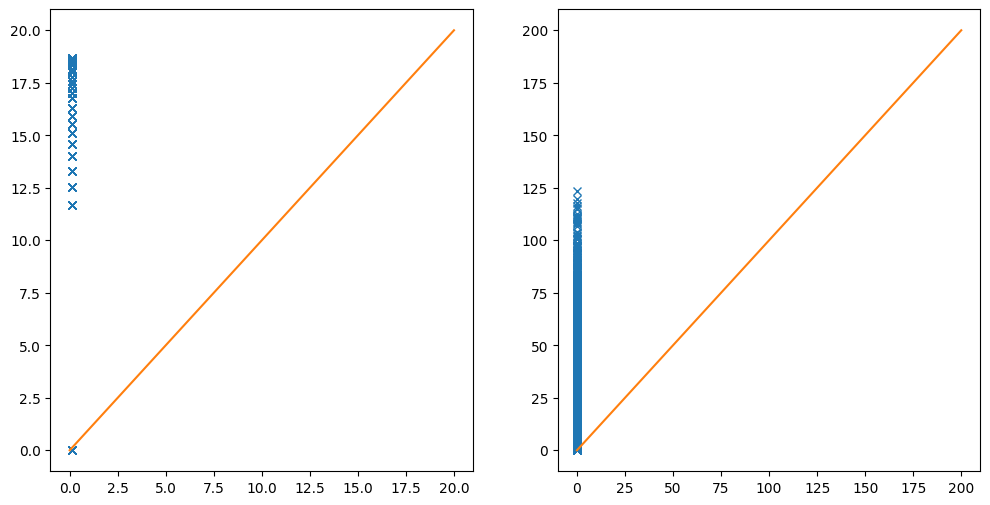

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         7 variables are exactly at the bounds

At iterate    0    f=  5.91219D+07    |proj g|=  4.22128D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.308  0.813E-03    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.150  0.814E-03    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000071   [Radiance 0.660 micron]


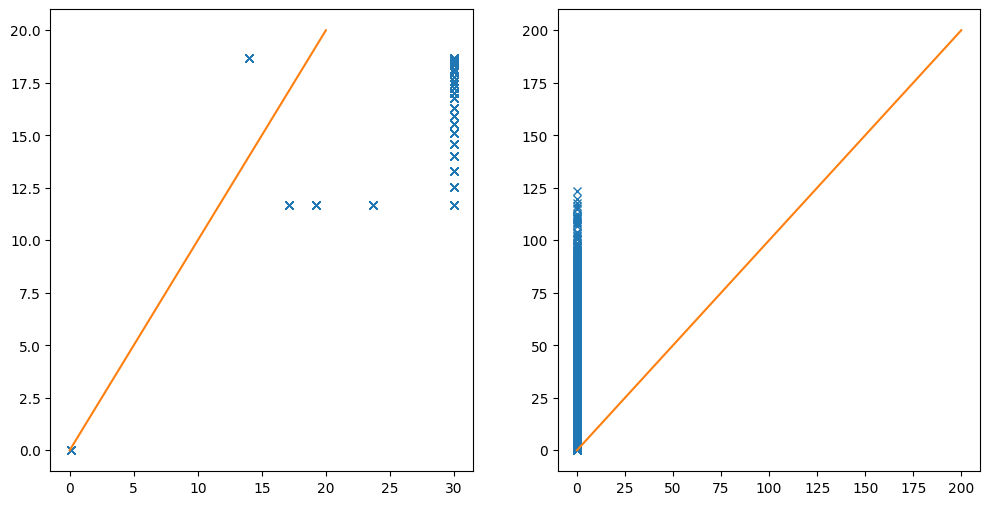

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.243  0.248E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.249E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


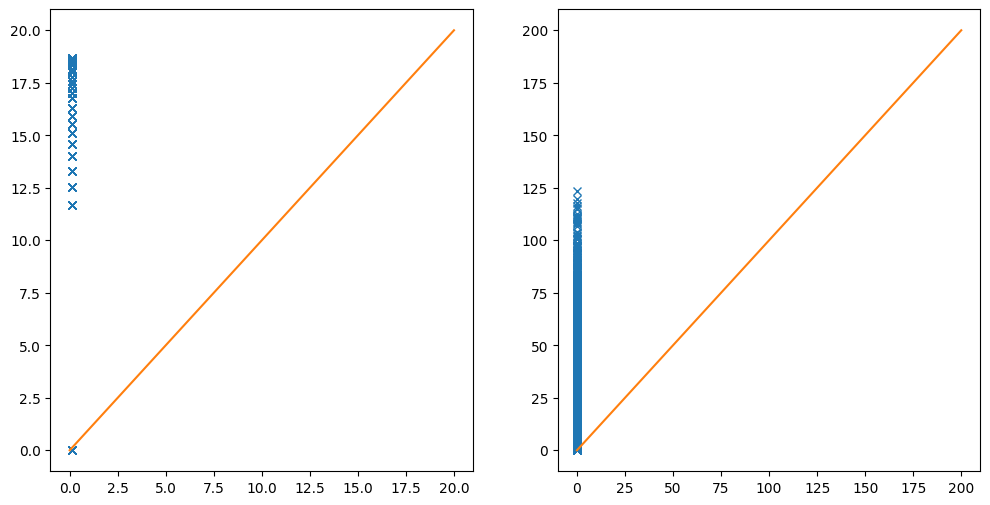

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.313  0.876E-03    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.155  0.877E-03    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000070   [Radiance 0.660 micron]


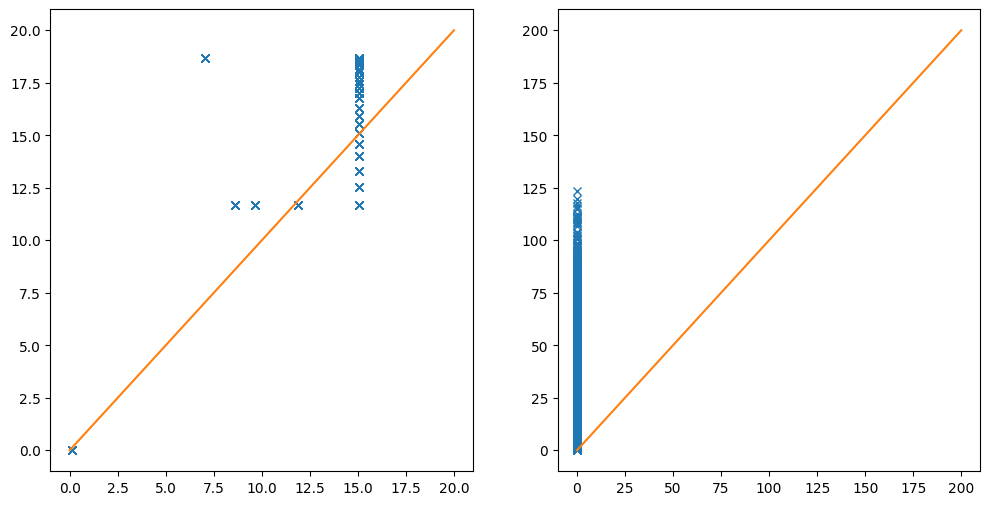

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.243  0.248E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.249E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


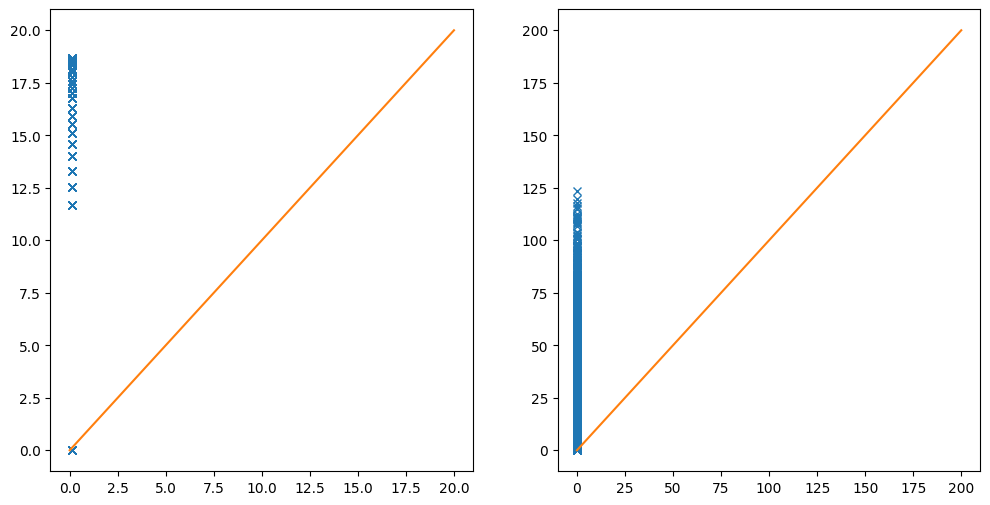

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.243  0.248E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.249E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


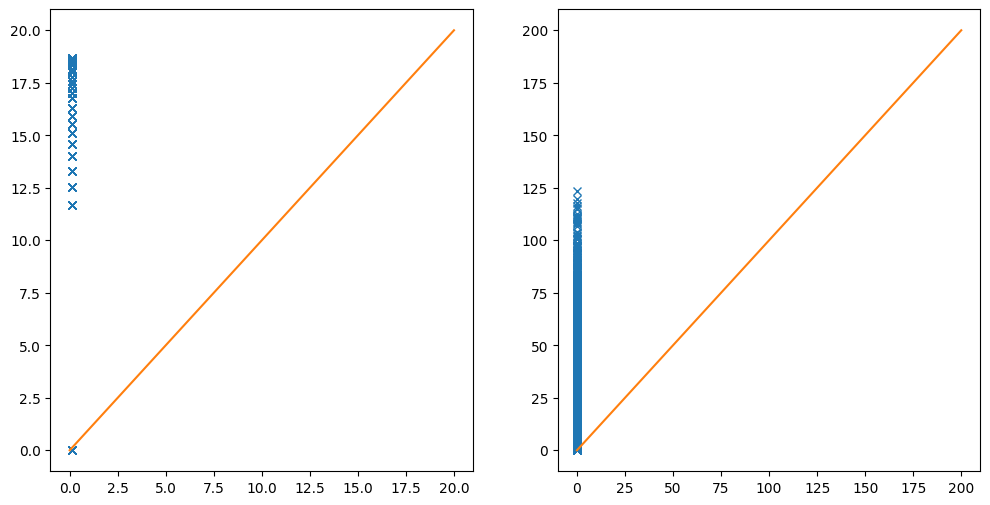

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.243  0.248E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.249E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


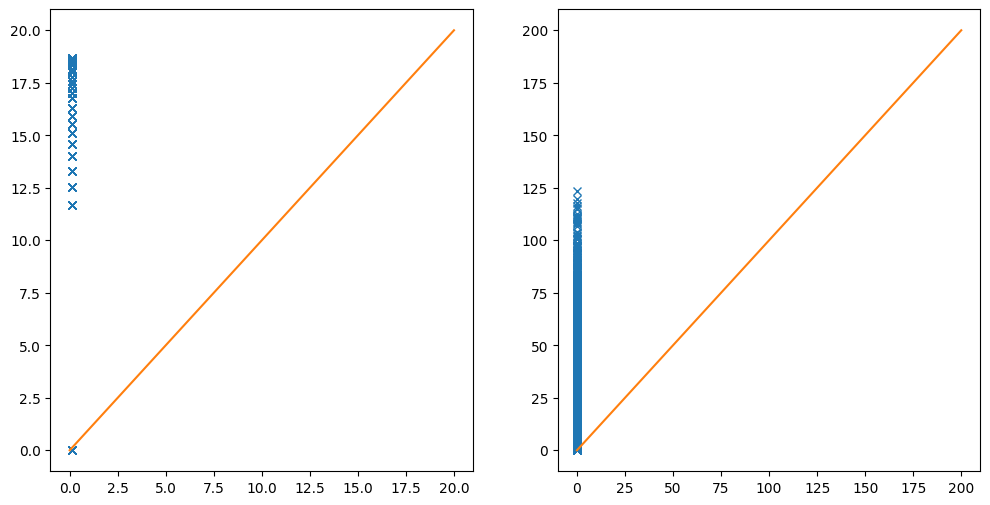


At iterate    1    f=  5.91218D+07    |proj g|=  4.22127D+00


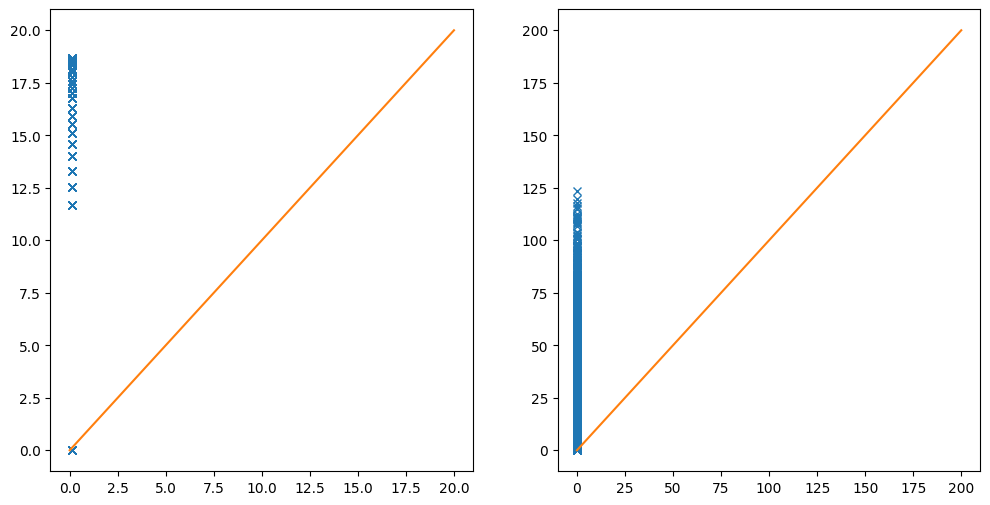


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      7     24     0    23   4.221D+00   5.912D+07
  F =   59121823.201204367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
------ Epoch 3 ------
------ Optimizing Density ------
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.243  0.248E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.249E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


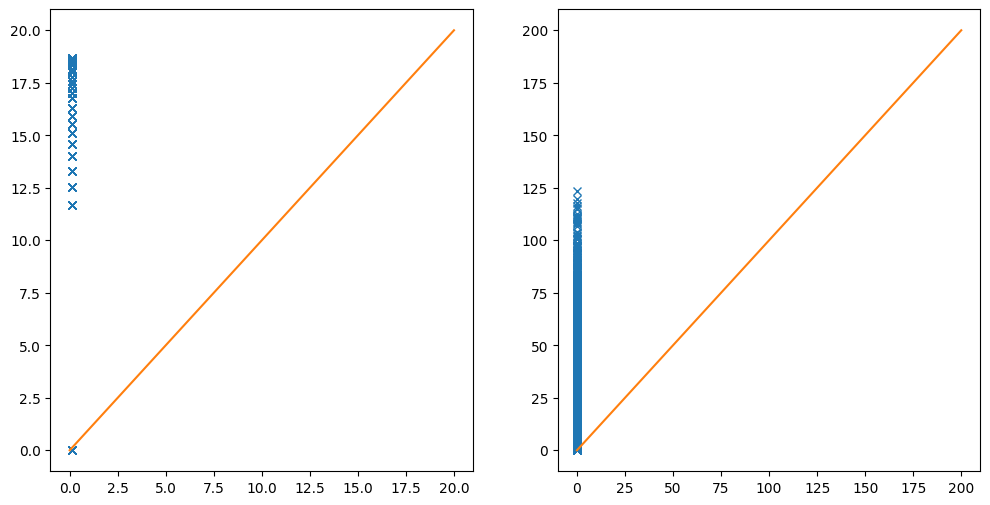

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9037     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91162D+05    |proj g|=  1.73531D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.947  0.688E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.928  0.551E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -3.191  0.478E-01    31984    78.91  0.308   [Radiance 0.660 micron]
     4  -4.080  0.294E-01    32036    79.17  0.309   [Radiance 0.660 micron]
 ! Iterations:      4     Final Criterion:  0.000083   [Radiance 0.660 micron]


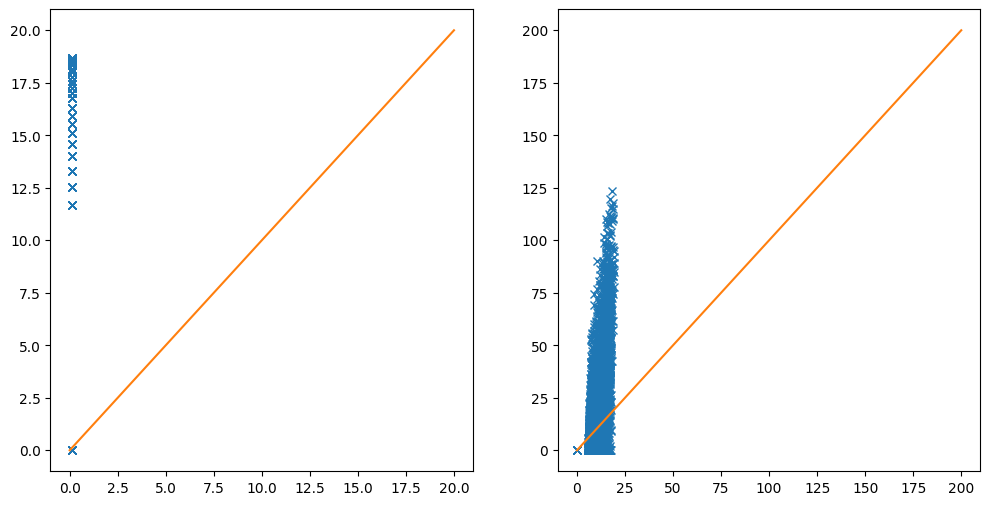

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.244  0.285E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.287E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


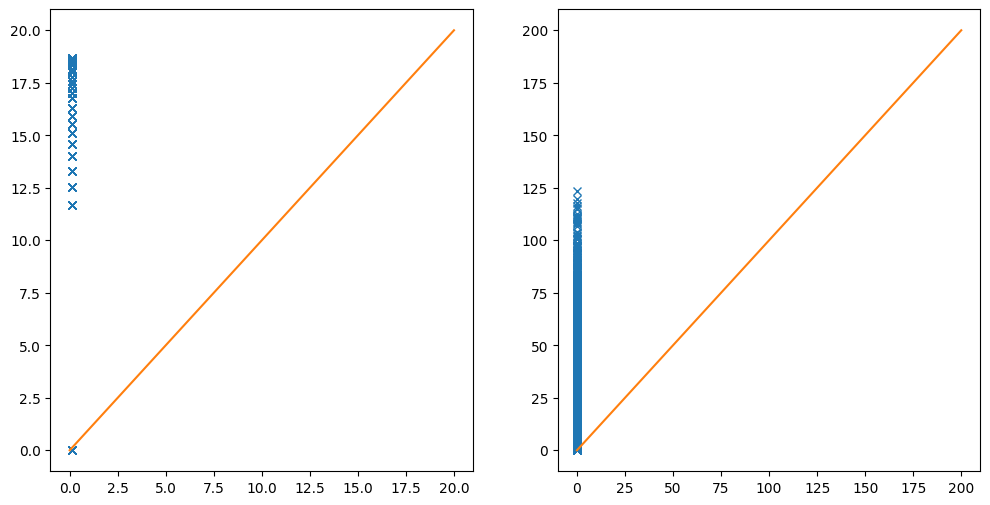

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.126  0.327E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -2.388  0.278E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -3.993  0.277E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -5.239  0.277E-01    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      4     Final Criterion:  0.000006   [Radiance 0.660 micron]


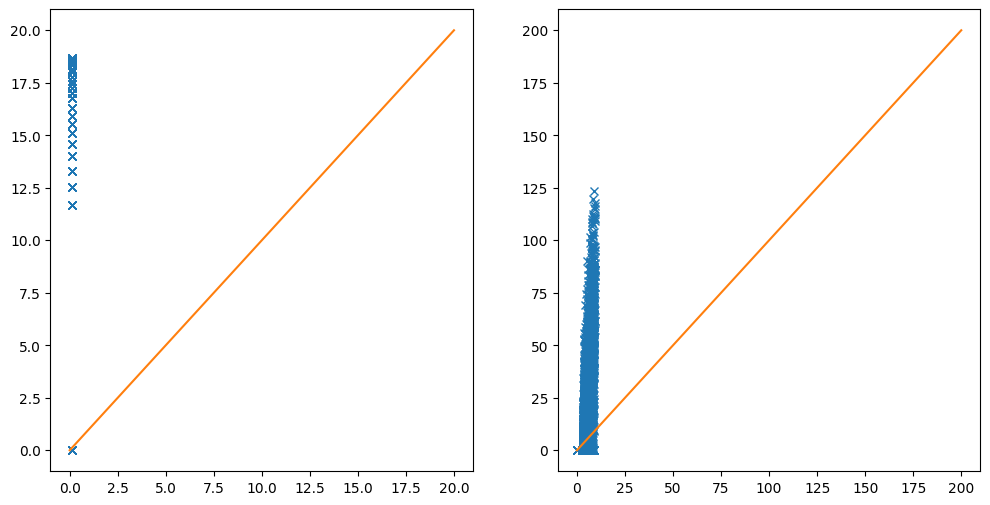

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.244  0.324E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.325E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


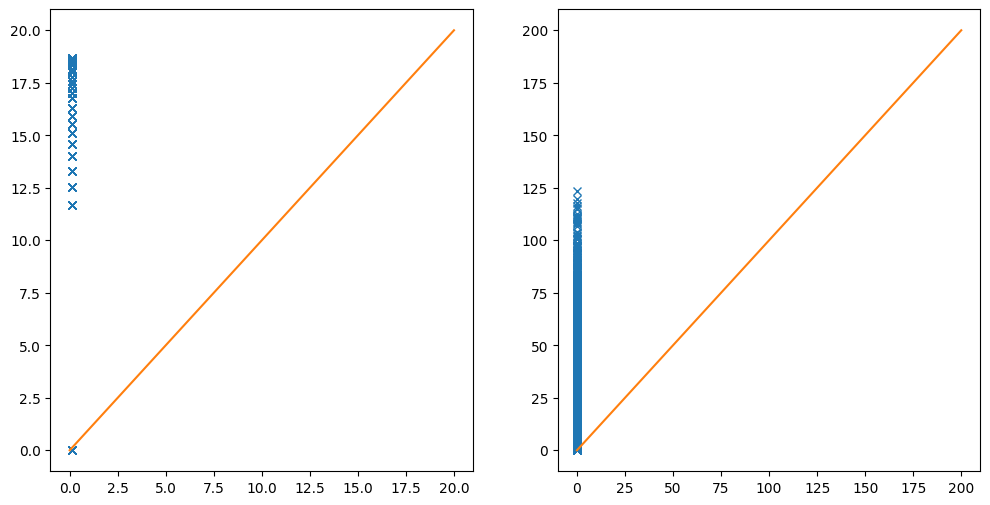

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.244  0.324E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.325E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


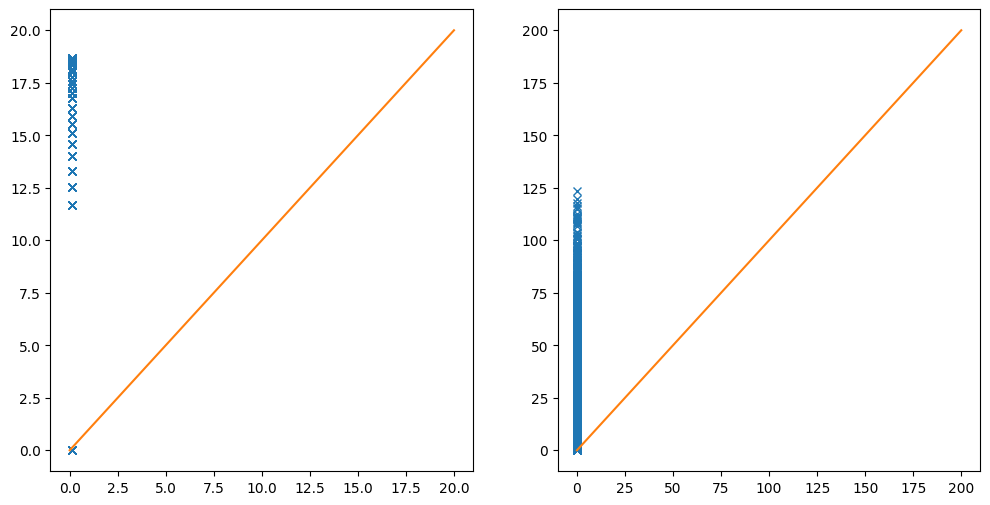

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.365  0.153E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -2.931  0.140E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -4.823  0.140E-01    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000015   [Radiance 0.660 micron]


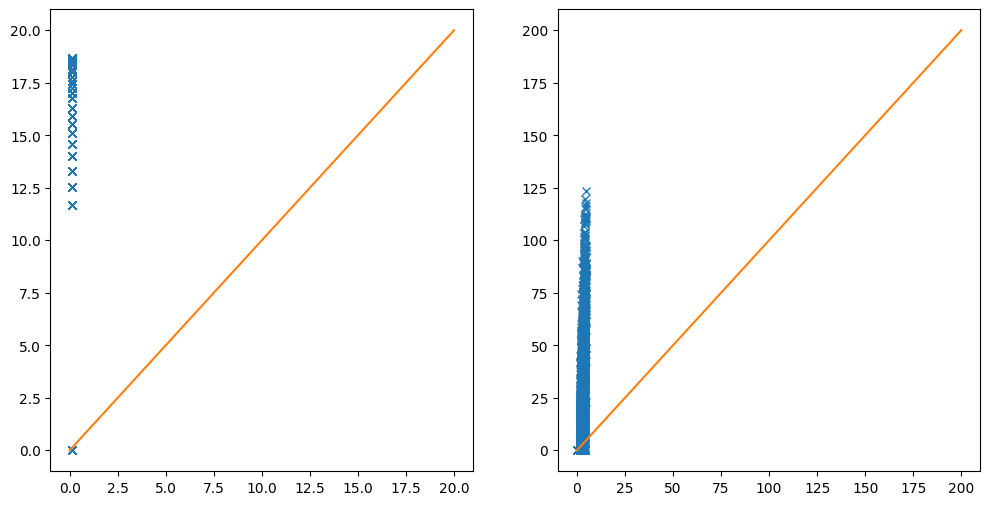

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.245  0.364E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.365E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


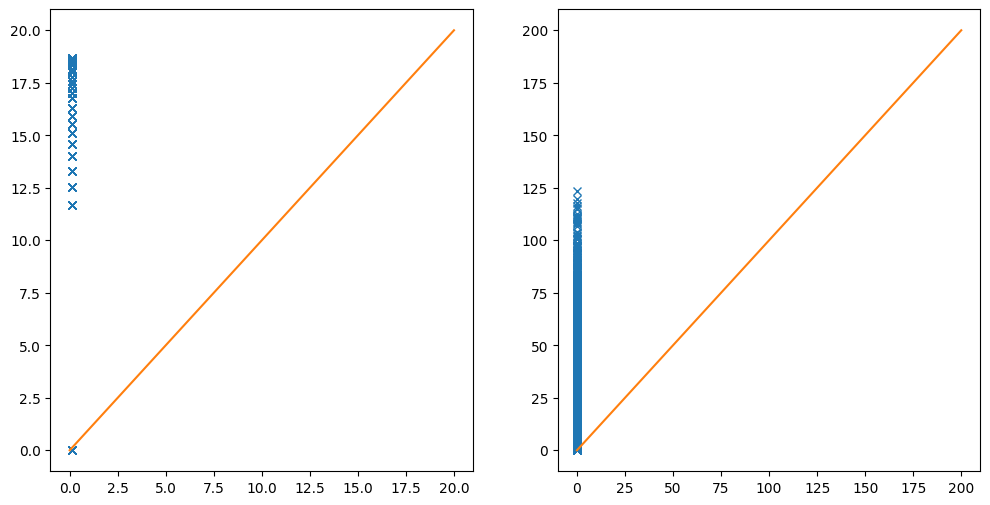

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.245  0.364E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.365E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


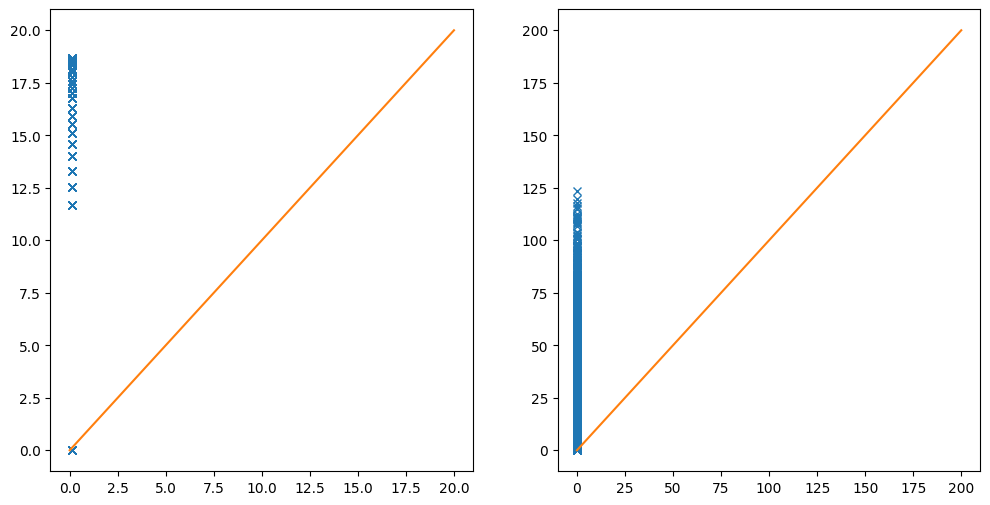

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.642  0.735E-02    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -3.552  0.706E-02    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -5.757  0.706E-02    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000002   [Radiance 0.660 micron]


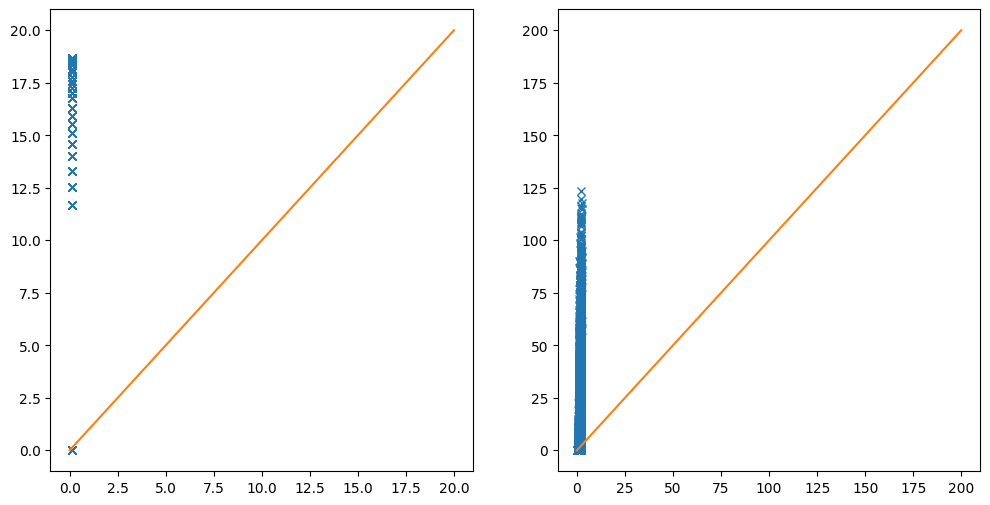

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.245  0.408E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.410E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


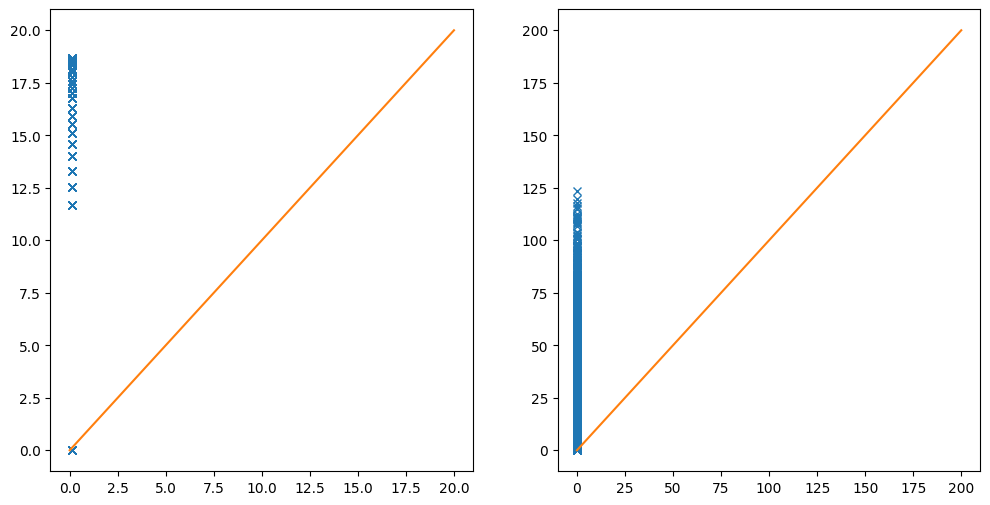


           * * *
------ Epoch 4 ------
------ Optimizing Reff ------

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9037      1     11      1     0     0   1.735D+00   5.912D+05
  F =   591161.51384747436     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.245  0.408E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.410E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


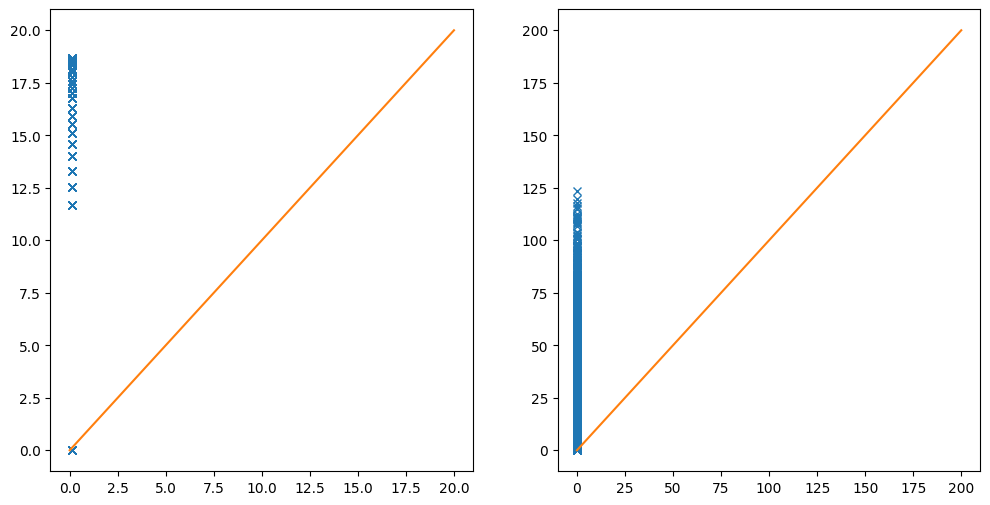

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91079D+07    |proj g|=  4.22127D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.326  0.118E-02    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.172  0.118E-02    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000067   [Radiance 0.660 micron]


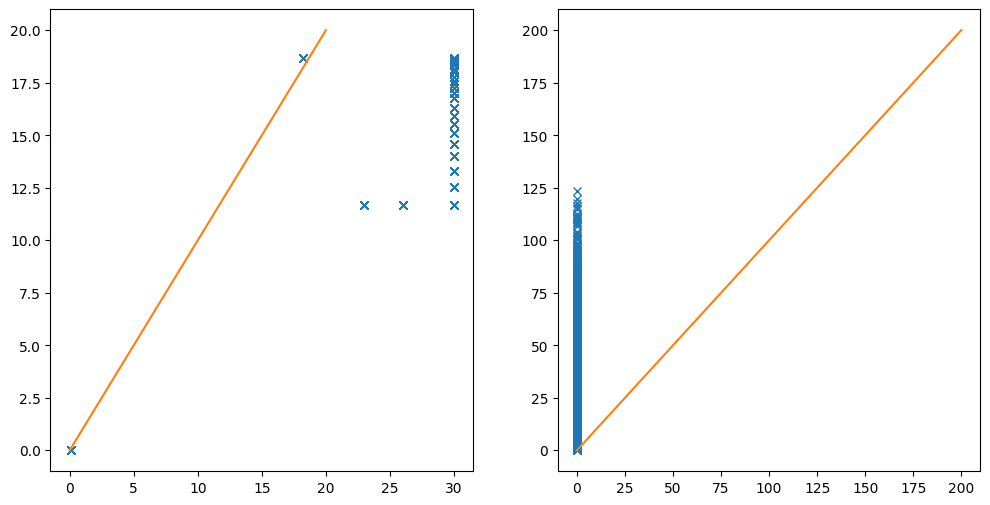

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.245  0.409E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.411E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


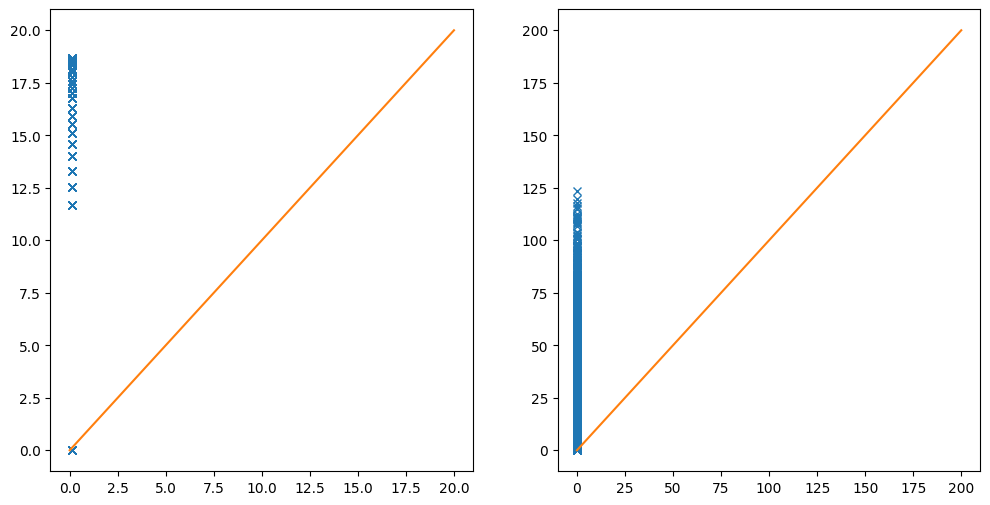

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.330  0.127E-02    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.178  0.127E-02    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000066   [Radiance 0.660 micron]


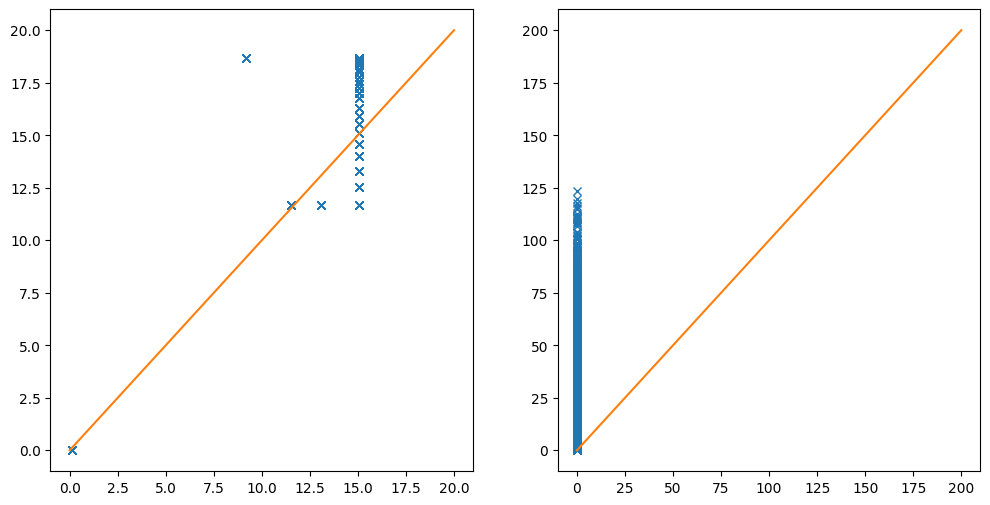

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.245  0.410E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.412E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


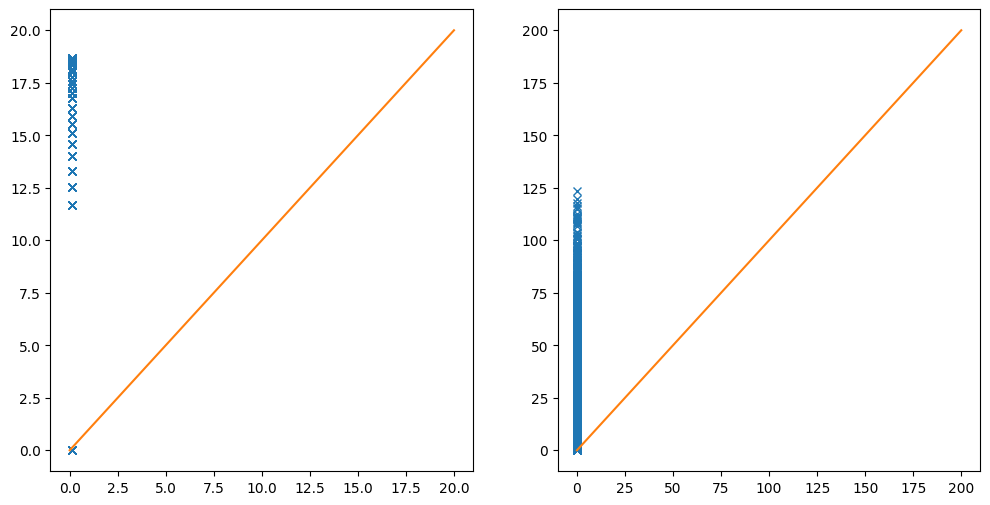

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.245  0.410E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.412E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


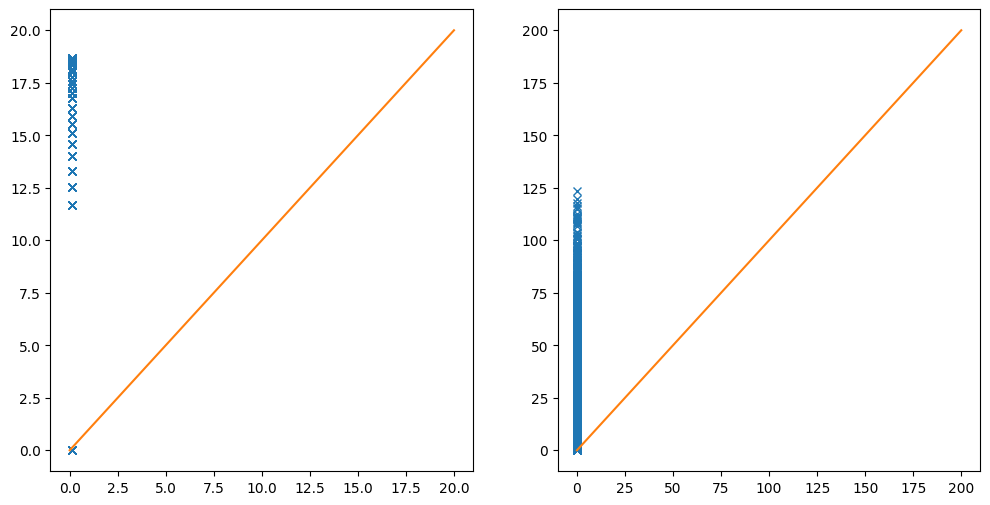

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.245  0.410E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.412E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


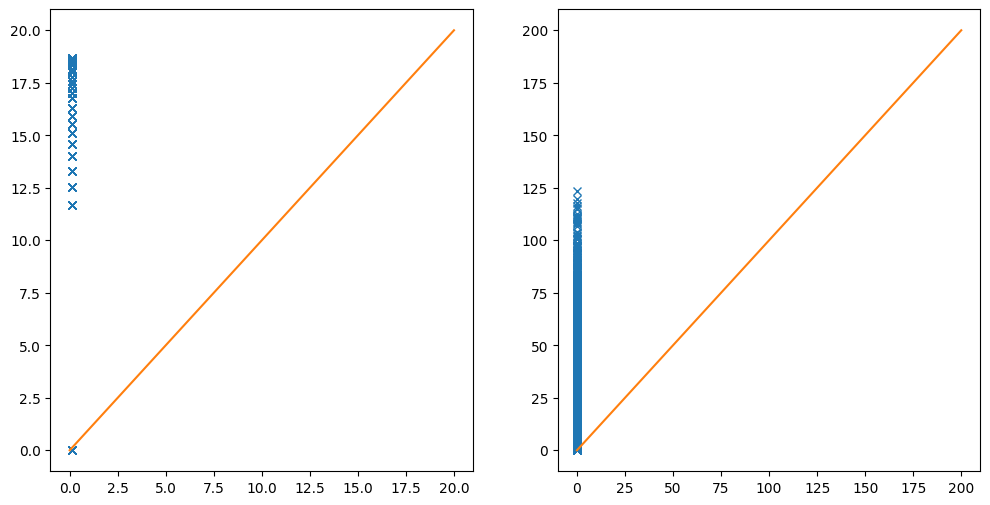


At iterate    1    f=  5.91078D+07    |proj g|=  4.22126D+00


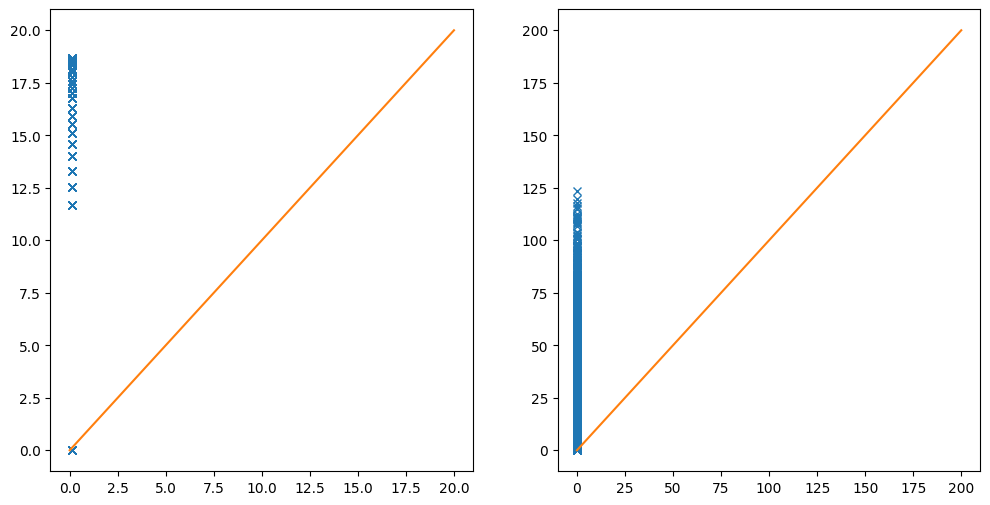


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *
------ Epoch 5 ------
------ Optimizing Density ------

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      7     25     0    24   4.221D+00   5.911D+07
  F =   59107830.735734411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.245  0.410E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.412E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


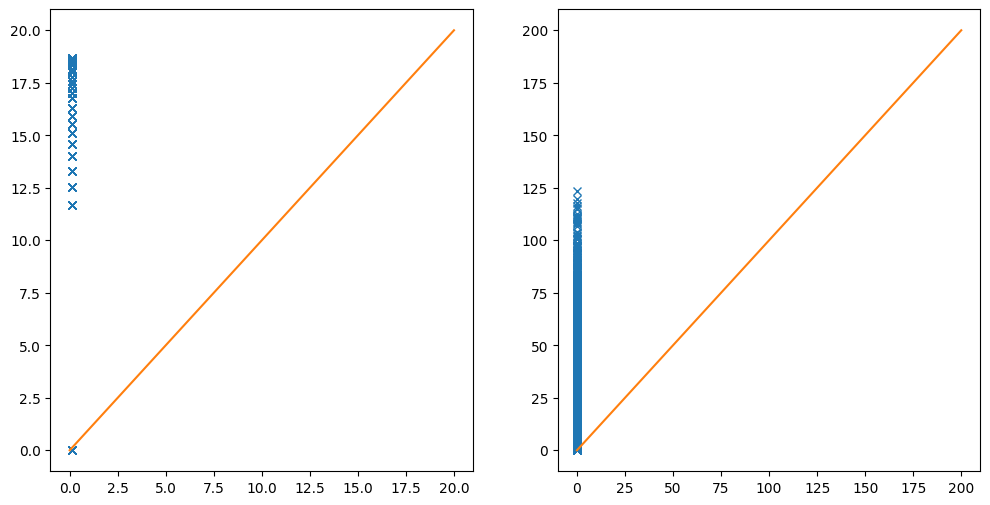

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9037     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91030D+05    |proj g|=  1.71709D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.949  0.683E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.933  0.547E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -3.200  0.475E-01    31984    78.91  0.308   [Radiance 0.660 micron]
     4  -4.091  0.298E-01    32035    79.17  0.309   [Radiance 0.660 micron]
 ! Iterations:      4     Final Criterion:  0.000081   [Radiance 0.660 micron]


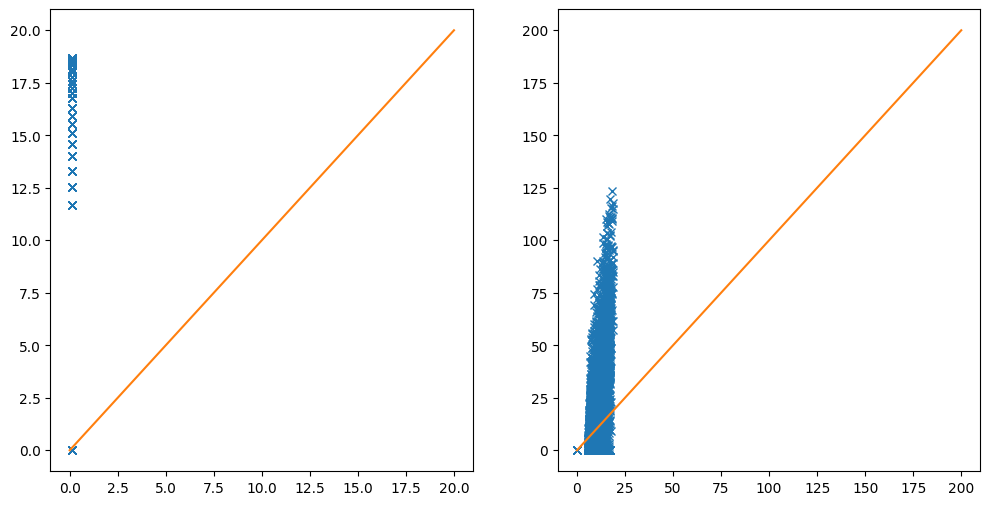

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.246  0.448E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.450E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


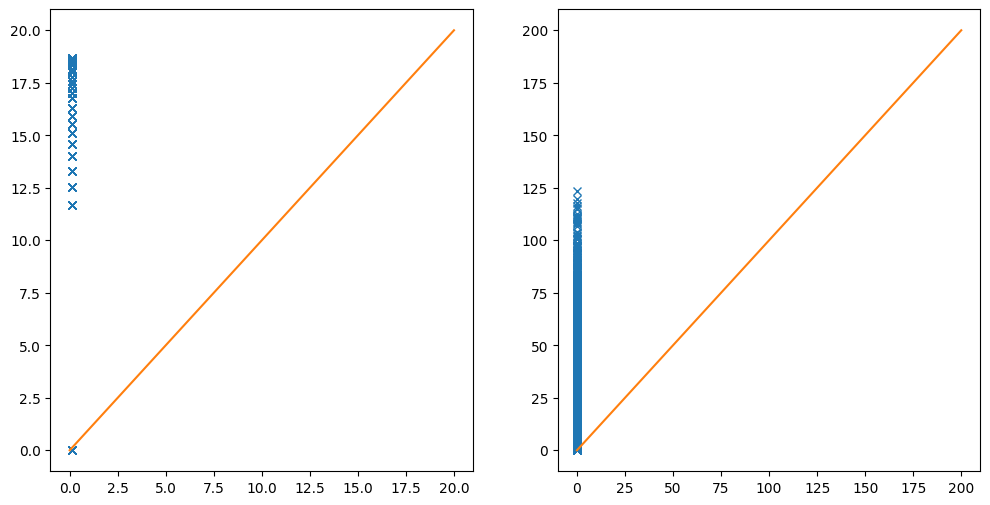

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.128  0.324E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -2.394  0.277E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -4.001  0.275E-01    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000100   [Radiance 0.660 micron]


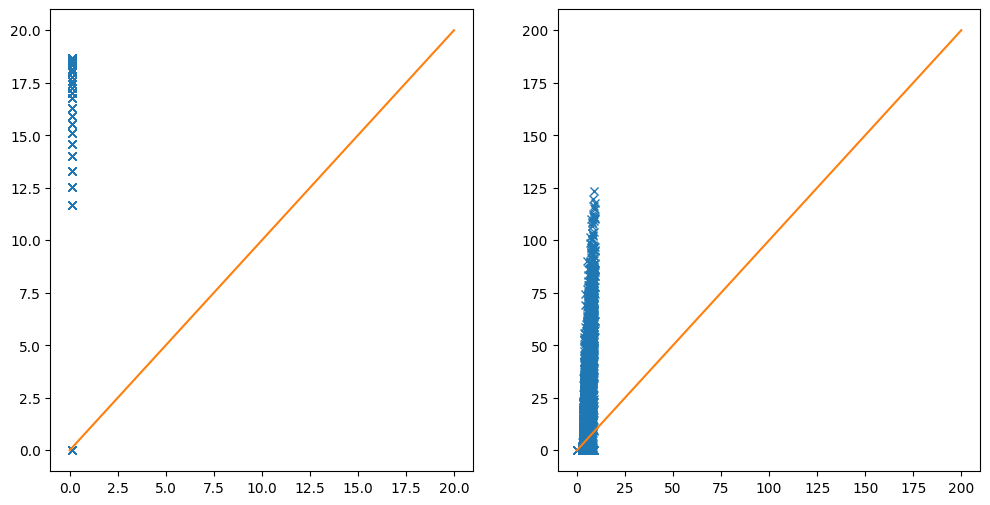

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.247  0.487E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.489E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


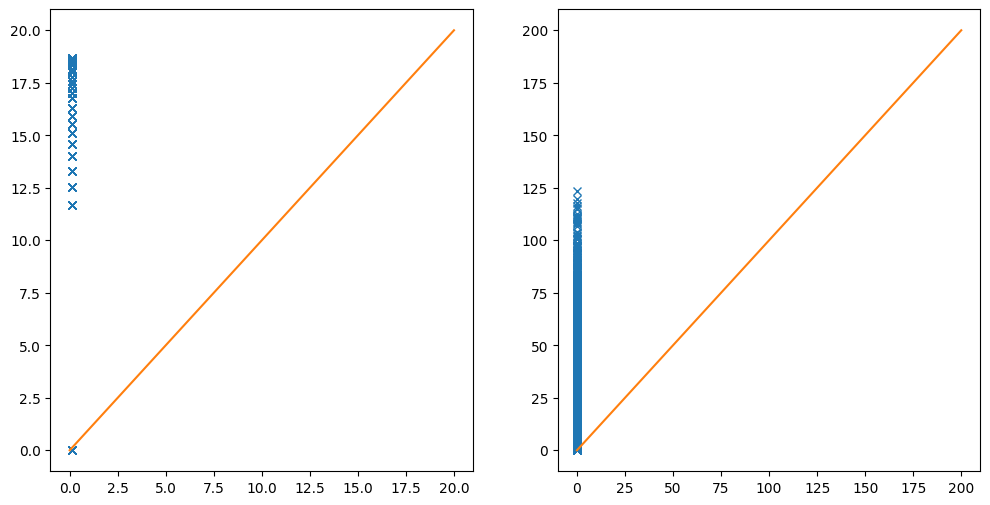

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.247  0.487E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.489E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


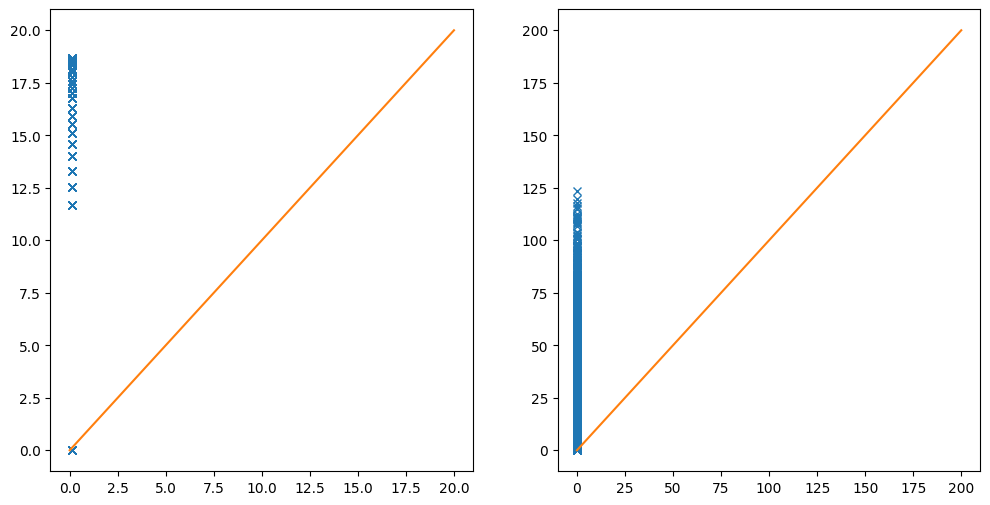

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.367  0.152E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -2.937  0.139E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -4.831  0.139E-01    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000015   [Radiance 0.660 micron]


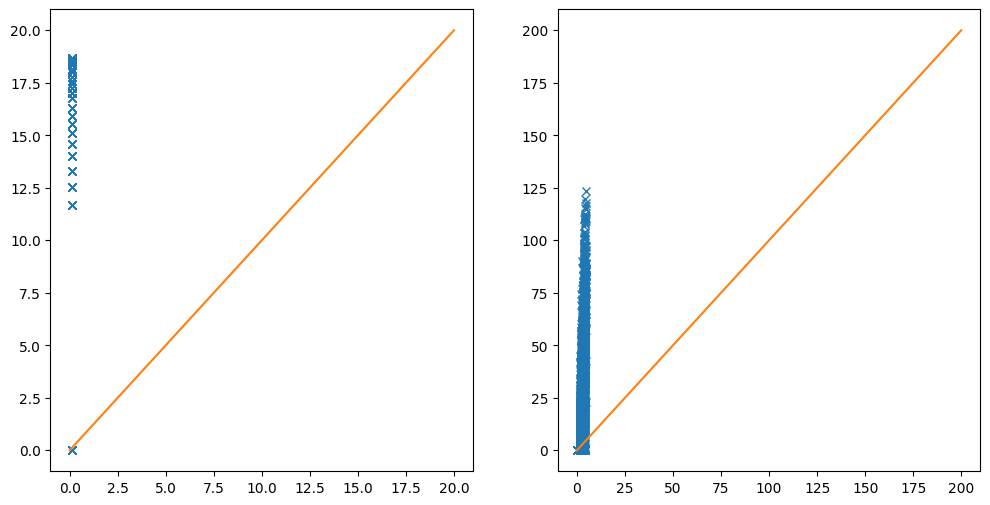

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.247  0.527E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.530E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


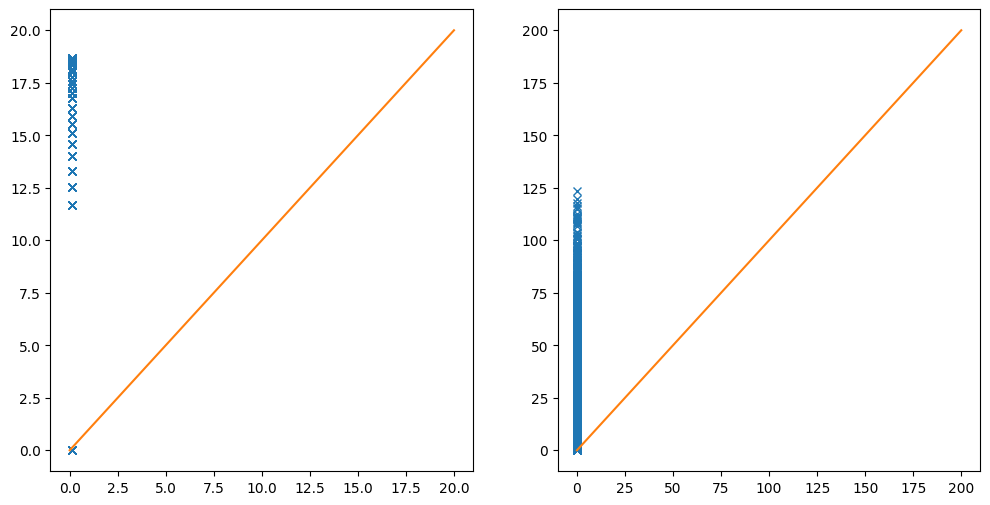

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.247  0.528E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.530E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


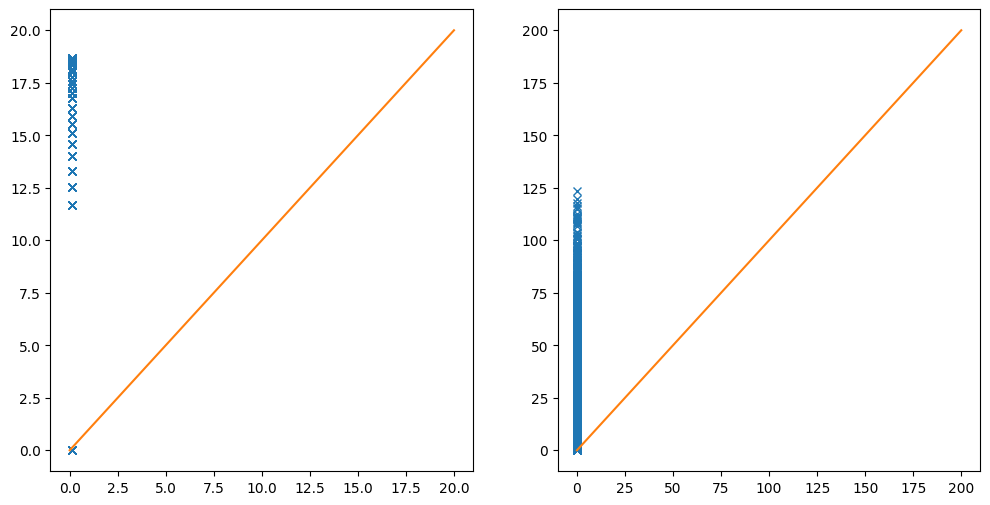

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.644  0.731E-02    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -3.558  0.703E-02    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -5.766  0.702E-02    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000002   [Radiance 0.660 micron]


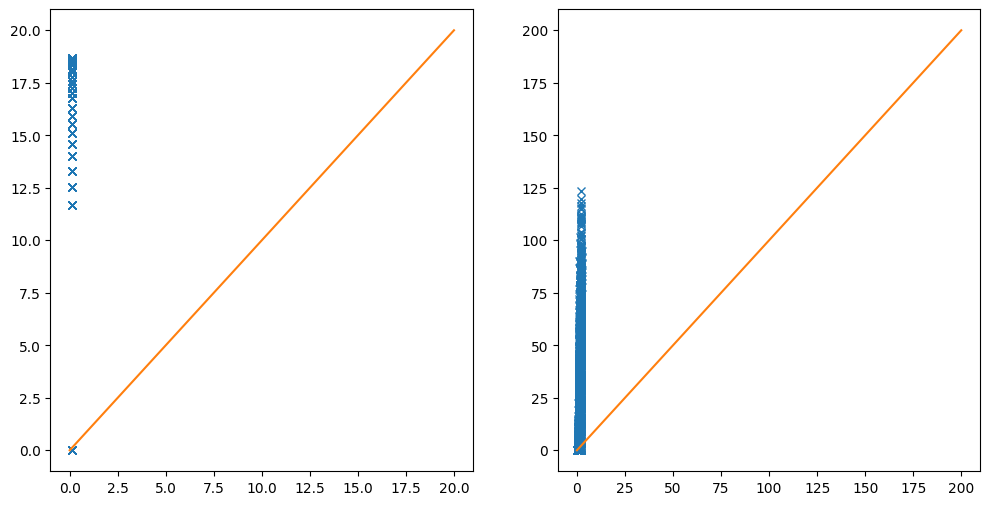

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.248  0.573E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.575E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


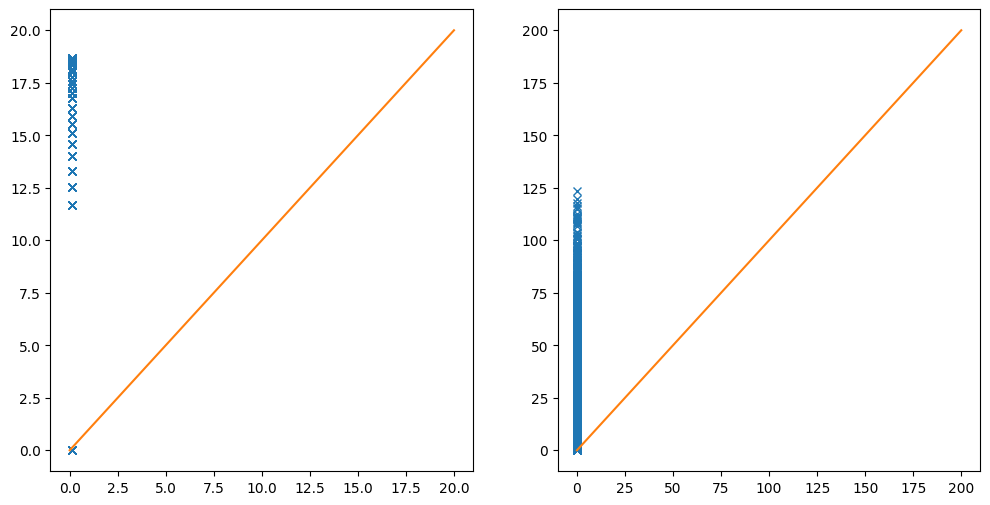


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9037      1     11      1     0     0   1.717D+00   5.910D+05
  F =   591030.34496618249     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


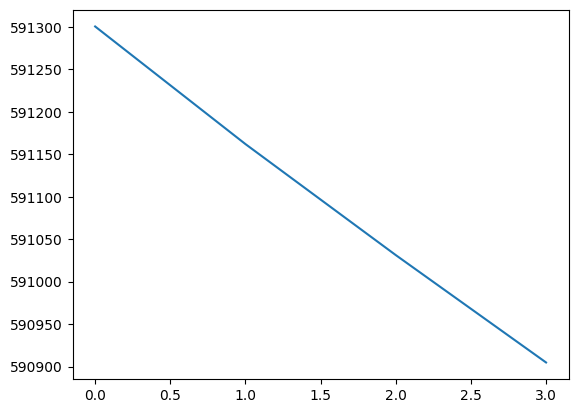

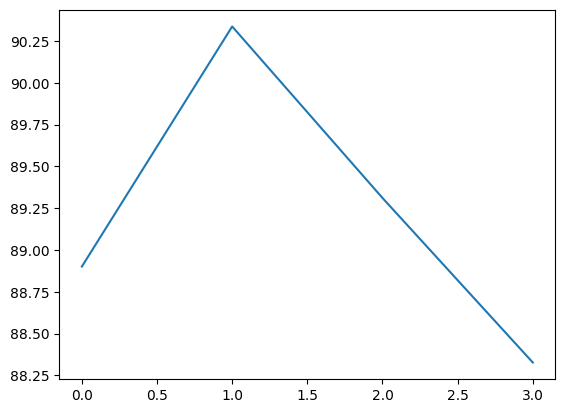

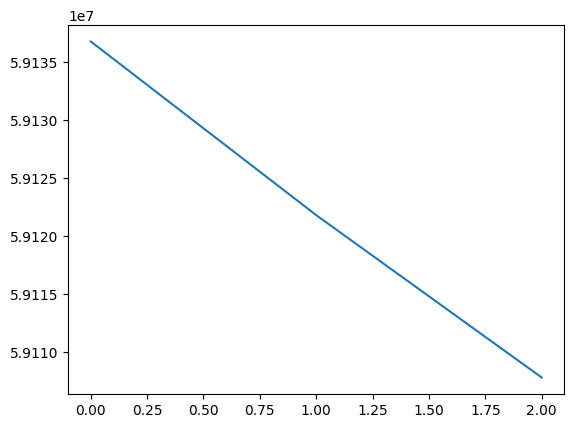

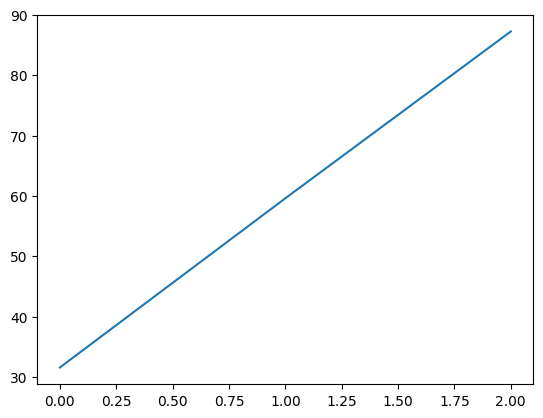

------ Epoch 6 ------
------ Optimizing Reff ------
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.248  0.573E-04    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -4.100  0.575E-04    31968    78.82  0.308   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


In [7]:
import copy
#make density geometric_extinction instead of lwc
solvers[.66].medium['cloud'].attrs["density_name"] = "geometric_extinction"
solvers[.66].medium['cloud'] = solvers[.66].medium['cloud'].rename_vars({"density" : 'lwc'})
solvers[.66].medium['cloud']["density"] = (("x", "y", "z"), 3e6 * solvers[.66].medium['cloud'].lwc.data / (2 * 997.0 * solvers[.66].medium['cloud'].reff.data))
solvers[.66].medium['cloud'].density.data = np.where(np.isnan(solvers[.66].medium['cloud'].density.data), 0, solvers[.66].medium['cloud'].density.data)
solvers[.66].medium['cloud'].density.data = np.where(np.isinf(solvers[.66].medium['cloud'].density.data), 0, solvers[.66].medium['cloud'].density.data)
solvers_reconstruct = copy.deepcopy(solvers)

#make initial guess
solvers_reconstruct[.66].medium['cloud'].veff.data = carved_volume.mask.data.astype(float)*0 + .1
solvers_reconstruct[.66].medium['cloud'].reff.data = carved_volume.mask.data.astype(float)*0 + 10
solvers_reconstruct[.66].medium['cloud'].density.data = carved_volume.mask.data.astype(float)*0
iter = 50
scale_factor = 2
reff_losses = []
density_losses = []
reff_grads = []
density_grads = []
for i in range(iter):
    print("------ Epoch " + str(i) + " ------")
    if i == 0:
        print("------ Optimizing Density and Reff ------")
        solvers_reconstruct, grad, loss = train_density(solvers_reconstruct, 1)
        density_losses.append(loss)
        density_grads.append(grad)
        solvers_reconstruct, grad, loss = train_reff(solvers_reconstruct, 1)
        reff_losses.append(loss)
        reff_grads.append(grad)
    elif i % 2 == 1:
        print("------ Optimizing Density ------")
        solvers_reconstruct, grad, loss = train_density(solvers_reconstruct, 1)
        density_losses.append(loss)
        density_grads.append(grad)
        
    else:
        print("------ Optimizing Reff ------")
        solvers_reconstruct, grad, loss = train_reff(solvers_reconstruct, 1)
        reff_losses.append(loss)
        reff_grads.append(grad)
    if(i % 5 == 0):
        py.plot(density_losses)
        #py.axhline(y=init_loss * .01, color='r', linestyle='--')
        py.show()
        py.plot(density_grads)
        py.show()
        py.plot(reff_losses)
        py.show()
        py.plot(reff_grads)
        py.show()

# for i in range(5):
#     solvers_reconstruct = train_reff_full(solvers_reconstruct, i+1)

In [ ]:
print(solvers_reconstruct[.66].medium['cloud'])